In [4]:
### RUN EVERY TIME: ECONOMIC INDICES RELEASES HISTORY EXTRACTING

In [5]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
import numpy as np
from datetime import date, datetime
from math import floor, ceil
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.x13 import x13_arima_analysis
from itertools import combinations_with_replacement
from sklearn.decomposition import PCA
import os
import gc
from joblib import Parallel, delayed
import re
from pandas.plotting import register_matplotlib_converters # Plotting
register_matplotlib_converters() # Plotting
import seaborn as sns

#%load_ext line_profiler

In [6]:
### RUN ONLY WHEN ARIMA X13 SA LAUNCHING 

### Warnings hiding:
import warnings
warnings.filterwarnings('ignore')
### Seasonal adjustment module paths set up:
%env X13PATH = C:\Users\ighar\AppData\Roaming\jupyter\x13as
%env X12PATH = C:\Users\ighar\AppData\Roaming\jupyter\x13as
#%env

env: X13PATH=C:\Users\ighar\AppData\Roaming\jupyter\x13as
env: X12PATH=C:\Users\ighar\AppData\Roaming\jupyter\x13as


In [7]:
### VERSION CONTROL

from platform import python_version
print('pandas version: ', pd.__version__)
print('python version: ', python_version())

pandas version:  0.25.3
python version:  3.7.4


In [8]:
### RUN EVERY TIME: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable']
### Raw data path and sheets:
str_path_bb_idx_source = 'Data_Files/Source_Files/Bloomberg_Eco_Indices.xlsx'
str_all_sheet = 'All Eco Const'
### Flags data path and sheets:
str_path_bb_idx_flags = 'Data_Files/Source_Files/Bloomberg_Eco_Flags_Extended.xlsx'
str_flag_sheet = 'Bloomberg Description'
### Source data constants:
int_idx_cols = 12
### HDF file with converted source data:
str_path_bb_fcast_hdf = 'Data_Files/Source_Files/Bloomberg_Forecasts_matrix.h5' ### LINE TO ADD
str_key_flags = 'flags_exported' ### Acadian flags list
str_key_exported = 'all_idx_exported' ### Raw export with only replacing zero dates and after 2021-01-01 dates with np.NaN
str_key_raw_filled = 'all_idx_raw_filled' ### Raw export with initial dates, dates gaps, absent date columns filled
str_key_raw_history = 'raw_history' ### Export with all the corrections and fillings (restructured to [Index_Name -> Data_Date -> Observation_Date] | Value series)
str_key_bday_history = 'bday_history' ### Raw history vector with observation dates moved to nearest future business dates
str_key_types_info = 'types_info' ### Dataframe with 'Type_Prime' / 'Sub_Type' / 'Region' groups descriptions
str_key_flags_typed = 'flags_typed' ### Dataframe with economic indices descriptions taking into account 
str_key_survey_history = 'survey_history' ### Release values are replaced with Survey Medians to normalize it ### LINE TO ADD
str_key_norm_filled = 'all_idx_norm_filled' ### Normalized values with initial dates, dates gaps, absent date columns filled
str_key_cleared = 'all_idx_cleared' ### LINE TO ADD
str_key_weighted = 'all_idx_weighted' ### LINE TO ADD
str_key_announce = 'announce_factor' ### LINE TO ADD
str_key_announce_simple = 'announce_simple' ### LINE TO ADD
str_key_disagreement = 'disagreement_factor' ### LINE TO ADD
str_key_disagreement_simple = 'disagreement_simple' ### LINE TO ADD
str_key_revision = 'revision_factor' ### LINE TO ADD
str_key_revision_simple = 'revision_simple' ### LINE TO ADD
str_key_total_surprise = 'total_factor' ### LINE TO ADD
str_key_total_surprise_simple = 'total_simple' ### LINE TO ADD
str_key_signs = 'all_signs' ### LINE TO ADD
### HDF file with matrices:
str_path_bb_matrix_ant_hdf = 'Data_Files/Source_Files/Matrix_Eco_Indices_ant.h5'
str_path_bb_matrix_yoy_hdf = 'Data_Files/Source_Files/Matrix_Eco_Indices_yoy.h5'
str_path_survey_matrix_ant_hdf = 'Data_Files/Source_Files/Matrix_Eco_Surveys_ant.h5'
str_path_survey_matrix_yoy_hdf = 'Data_Files/Source_Files/Matrix_Eco_Surveys_yoy.h5'
str_key_matrix_z = 'matrix_cube_z_scored'
### HDF file with diagonals:
str_path_bb_diag_hdf = 'Data_Files/Source_Files/Diag_Eco_Indices.h5'
str_key_diag_agg_z_lim = 'aggregated_diagonal_z_limited'
### HDF file with weights collection:
str_path_bb_weights_hdf = 'Data_Files/Source_Files/FPC_Weights.h5'
### Observation axis range:
datetime_start = datetime(1984, 12, 31) # Start date for efficacy measures
date_start = datetime_start.date()
datetime_end = datetime(2020, 8, 31) # End date for efficacy measures
date_end = datetime_end.date()
idx_date_range = pd.date_range(date_start, date_end, freq = 'B')
datetime_basis = datetime(1993, 12, 31) # End date for efficacy measures
date_basis = datetime_basis.date()
### Gaps filling options:
int_revision_shift = 1
int_final_shift = 2
int_first_mean_length = 12
dict_final_only_lag = {}
dict_final_only_lag['Quarterly'] = 90 // 2
dict_final_only_lag['Monthly'] = 30 // 2
dict_final_only_lag['Other'] = 7 // 2
### Cumprod shifts for monthly data frequency:
dict_cumprod_step = {}
dict_cumprod_step['MoM%'] = 1
dict_cumprod_step['QoQ%'] = 3
dict_cumprod_step['YoY%'] = 12
### Stock-like series shifts for YoY transformation:
dict_yoy_shift = {}
dict_yoy_shift['Monthly'] = 12
dict_yoy_shift['Quarterly'] = 4
dict_yoy_shift['Other'] = 52
### Stock-like series shifts for QoQ transformation:
dict_qoq_shift = {}
dict_qoq_shift['Monthly'] = 4
dict_qoq_shift['Other'] = 13
### Stock-like series shifts for MoM transformation:
dict_mom_shift = {}
dict_mom_shift['Monthly'] = 1
dict_mom_shift['Other'] = 4
### Group tickers rebasing options:
int_not_to_rebase_term = 7 ### Term in years for min ticker data date when we do not need to rebase it with basis group ticker
int_not_to_rebase_diff = 2 ### Minimal difference in years between basis ticker and other group ticker min date when we need to rebase group ticker
### Z-scoring options:
int_winsorize_bound = 4
flo_winsorize_tolerance = 0.0001
int_winsorize_steps_limit = 5
### Diagonal options:
int_min_years_z_score = 3
int_max_years_z_score = 10
date_diag_start = datetime(1994, 1, 1)
### Regions weights:
dict_region_weight = {}
dict_region_weight['US'] = 0.50
dict_region_weight['Europe'] = 0.25
dict_region_weight['Japan'] = 0.15
dict_region_weight['UK'] = 0.10
### Business year length:
int_bus_year = 260
### CPU count to use during multiprocessing:
int_cpu_count = 4
### Tickers to limited replace NaN revision values with release values:
idx_to_fill_empty_revision = ['ADP CHNG Index', 'ATIPIMM Index', 'BEUER Index', 'CONCCONF Index', 'CPTICHNG Index', 'DGNOCHNG Index', 'DGNOXTCH Index', 
                              'ECO1GFKC Index', 'EUBCI Index', 'EUCPTSAM Index', 'EUESEMU Index', 'EUICEMU Index', 'EUITEMUM Index', 'EUPPEMUM Index', 
                              'EUSCEMU Index', 'FIIPSAIM Index', 'FPIPMOM Index', 'FRMPMOM Index', 'FRPIMOM Index', 'GKRSNEWY Index', 'GRFRIAMM Index', 
                              'GRIFPBUS Index', 'GRIFPCA Index', 'GRIFPEX Index', 'GRIORTMM Index', 'GRIPIMOM Index', 'GRUECHNG Index', 'IEUERT Index',
                              'IMP1CHNG Index', 'INJCJC Index', 'INJCSP Index', 'INSEPROD Index', 'INSESYNT Index', 'IP CHNG Index', 'ITBCI Index', 'ITORTSAM Index',
                              'ITPRSANM Index', 'ITPSSA Index', 'ITVHYOY Index', 'JNTIAIAM Index', 'JNTIAMOM Index', 'MTIBCHNG Index', 'MWINCHNG Index', 
                              'NEIP20MM Index', 'NFP TCH Index', 'PCE CHNC Index', 'PITLCHNG Index', 'PTIPTOTM Index', 'PTRTIMOM Index', 'RSTAMOM Index', 
                              'RSTAXAG% Index', 'SLIOINMM Index', 'SPIOYOY Index', 'SPROCHNG Index', 'SPRSRGIY Index', 'SVBTSI Index', 'TMNOCHNG Index', 
                              'UKAWMWHO Index', 'UKIPIMOM Index', 'UKMPIMOM Index', 'UKPPIINC Index', 'UKPPIOC Index', 'UKRVAMOM Index', 'UKRVINFM Index',
                              'UKUEMOM Index', 'USMMMNCH Index']
### NBER Recession periods collection:
str_path_nber_hdf = 'Data_Files/Source_Files/NBER_Chronology.h5'
str_nber_periods_key = 'nber_recession_periods'
### CFNAI data collection:
str_path_cfnai_hdf = 'Data_Files/Source_Files/CFNAI.h5'
str_cfnai_full_key = 'cfnai_all_indices'
### MSCI World Index data collection:
str_path_msci_hdf = 'Data_Files/Source_Files/MSCI_World_Index.h5'
str_msci_world_key = 'msci_world'
str_msci_market_down_key = 'msci_recession_periods'
### PC FPC weights collection:
str_path_fpc_hdf = 'Data_Files/Source_Files/FPC_Weights.h5'
str_weights_key = 'global_diagonal_full_yoy' # 'global_diagonal_full_mom' # 
### Economic Surprise & Survey Disagreement options:
list_smooth = [1, 3, 12] ### LINE TO ADD
list_clip = [-4.0, 4.0] ### LINE TO ADD
int_min_tickers_to_go = 5 ### LINE TO ADD
int_obs_num_win = 1 * int_bus_year ### LINE TO ADD
int_disagreement_max = 5 * int_bus_year ### LINE TO ADD
int_disagreement_min = 1 * int_bus_year ### LINE TO ADD
int_bus_month = 22 ### LINE TO ADD
int_bus_min = 1 ### LINE TO ADD
### Percentiles calculation options:
int_ptile_months_win = 10 * 12 ### LINE TO ADD
int_ptile_months_min = 1 * 12 ### LINE TO ADD
tumbler_to_plus = 0.6 ### LINE TO ADD
tumbler_to_minus = 0.4 ### LINE TO ADD

In [9]:
### DEFINING OBSERVATION DATE VECTOR EXTRACTION

def get_obs_date_vector(str_ticker, str_date, bool_exact_date = False, bool_drop_levels = False):
    ### Vector for exact date:
    if bool_exact_date:
        ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
    ### Vector for nearest date:        
    else:
        ### Loading full ticker series:        
        ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
        ### Extracting data for max date less or equal to needed date:
        ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
    ### Dropping constant index levels if needed:
    if bool_drop_levels:
        return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
    else:
        return ser_obs_date

In [10]:
### DEFINING WEIGHTED AVERAGE FOR DATAFRAME COLUMNS (PART OF THE PRODUCT CODE)

def columns_average(df_series, list_weights = False): 
    ### Single column check
    if (len(df_series.columns) > 1):
        ### Equal weights list creating:
        if isinstance(list_weights, bool):
            list_weights = [1] * len(df_series.columns)
        ### Dataframe of weights initialising:
        df_weights = pd.DataFrame(np.NaN, index = df_series.index, columns = df_series.columns)
        for iter_num, iter_col in enumerate(df_weights.columns):
            df_weights[iter_col] = list_weights[iter_num]
        ### Zeroing weights for NaN values:
        for iter_col in df_weights.columns:
            df_weights.loc[df_series[iter_col].isna(), iter_col] = 0
        ser_mean = (df_series.multiply(df_weights).sum(axis = 1)).div(df_weights.sum(axis = 1))    
        ### Results output:
        del df_series
        del df_weights    
        gc.collect()
    else:
        ser_mean = df_series.squeeze()
        del df_series
        gc.collect()        
    return ser_mean

In [11]:
### DEFINING EXPONENTIAL WEIGHT

def exp_weight_single(halflife_len = 3, num_element = 0):
    ### Weight calculating:
    num_period_factor = math.exp(math.log(0.5) / round(halflife_len))
    num_weight = np.exp(math.log(num_period_factor) * num_element)
    ### Result output:
    return num_weight

In [12]:
### DEFINING WEIGHTED AVERAGE

def weighted_average(ser_data, ser_weight = False, int_min_count = 0):
    ### Default output:
    num_result = np.NaN
    ### Checking for data presence:
    if (ser_data.count() > int_min_count):       
        ### Checking for weights dataset:
        if isinstance(ser_weight, bool):
            ### Calculating of simple average:
            num_result = np.nanmean(ser_data.values)
        else:
            ### Weights filtering:
            list_weight = ser_weight[ser_data.dropna().index].values
            ### Checking for weights presence:
            if np.nansum(list_weight):
                ### Data filtering:
                list_data = ser_data.dropna().values
                ### Weighted average calculating:
                num_result = np.nansum(list_data * list_weight) / np.nansum(list_weight)
    ### Results output:
    return num_result

In [10]:
### RUN TO RE-EXPORT DATA: SOURCE FILE EXPORT

### Reading excel file:
df_all_idx_raw = pd.read_excel(engine = 'openpyxl', io = str_path_bb_idx_source, sheet_name = str_all_sheet, skiprows = [0], index_col = None, header = None, 
                               parse_dates = False, na_values = list_na_excel_values, keep_default_na = False)
### List of dataframes for each eco index initializing:
list_idx_raw = []
### Extracting and converting each eco index data block separately to proper form:
for int_iter_idx_col in range(len(df_all_idx_raw.columns) // int_idx_cols):
    ### Extracting raw data:
    df_iter_idx_raw = df_all_idx_raw.iloc[All, (int_iter_idx_col * int_idx_cols) : ((int_iter_idx_col + 1) * int_idx_cols) - 1]
    ### Assigning colum names:
    df_iter_idx_raw.columns = df_iter_idx_raw.iloc[1]
    df_iter_idx_raw.columns.name = ''    
    ### Dropping empty rows:
    df_iter_idx_raw.dropna(how = 'all', inplace = True)
    ### Extracting eco index name:
    df_iter_idx_raw['Index_Name'] = df_iter_idx_raw.iloc[0, 0]
    ### Dropping identification rows (no longer needed):
    df_iter_idx_raw.drop([0, 1], axis = 0, inplace = True)
    ### Setting multiindex:
    df_iter_idx_raw.set_index(['Date', 'Index_Name'], drop = True, append = False, inplace = True)
    ### ADding dataframe to list:
    list_idx_raw.append(df_iter_idx_raw)
### Exported data aggregating:
df_all_idx_exported = pd.concat(list_idx_raw, axis = 0).swaplevel()
### Exported data saving:
df_all_idx_exported.index.names = ['Index_Name', 'Data_Date']
### Types converting for numerical data:
df_all_idx_exported = df_all_idx_exported.astype({'PX_LAST': 'float',
                                                  'ACTUAL_RELEASE': 'float',
                                                  'FIRST_REVISION': 'float',
                                                  'BN_SURVEY_NUMBER_OBSERVATIONS': 'float',
                                                  'BN_SURVEY_MEDIAN': 'float',
                                                  'BN_SURVEY_AVERAGE': 'float',
                                                  'FORECAST_STANDARD_DEVIATION': 'float'
                                                 })
### Zero dates dropping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] == 0, ['ECO_RELEASE_DT']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] == 0, ['FIRST_REVISION_DATE']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] == 0, ['ECO_FUTURE_RELEASE_DATE']] = np.NaN
### Incorrect dates droppping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] > 20210000, 'ECO_RELEASE_DT'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] > 20210000, 'FIRST_REVISION_DATE'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] > 20210000, 'ECO_FUTURE_RELEASE_DATE'] = np.NaN
### Dates formatting:
df_all_idx_exported['ECO_RELEASE_DT'] = pd.to_datetime(df_all_idx_exported['ECO_RELEASE_DT'].astype(str), format = '%Y%m%d')
df_all_idx_exported['FIRST_REVISION_DATE'] = pd.to_datetime(df_all_idx_exported['FIRST_REVISION_DATE'].astype(str), format = '%Y%m%d')
df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] = pd.to_datetime(df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'].astype(str), format = '%Y%m%d')
### Exported dataframe saving:
df_all_idx_exported.to_hdf(str_path_bb_fcast_hdf, key = str_key_exported, mode = 'w') ### LINE TO MODIFY

In [11]:
### RUN TO RE-EXPORT DATA: FLAGS FILE EXPORT

### Reading excel file:
df_flags = pd.read_excel(engine = 'openpyxl', io = str_path_bb_idx_flags, sheet_name = str_flag_sheet, usecols = list(range(38))[1: ], index_col = 0, 
                         skiprows = list(range(6)), header = 0, parse_dates = True, na_values = list_na_excel_values, keep_default_na = False)
### Dataframe transforming:
df_flags.dropna(how = 'all', inplace = True)
df_flags.index.name = 'Index_Name'
### Choosing columns to go on with:
df_flags = \
        df_flags[['CTRY', 'Type', 'Category', 'Negative', 'Security Description', 'SA/NSA', 'Processing', 'Index: Base', 'Type 2', 'INDX_SOURCE', 'DES_NOTES', 
                  'INDX_FREQ']]
### Columns renaming:
df_flags.columns = ['Region', 'Type_Prime', 'Category', 'Negative', 'Description', 'SA_Status', 'Processing', 'Base', 'Type_Second', 'Data_Source', 'Notes', 
                    'Frequency']
### Seasonality Adjustment Flag filling:
df_flags['SA_Status'] = df_flags['SA_Status'].fillna('Unclear')
### Processing Index separating:
df_flags['Processing'] = df_flags['Processing'].str.partition(': ')[0].str.strip()
### Base filling:
df_flags['Base'] = df_flags['Base'].fillna(-1)
### Euro countries region renaming:
df_flags.loc[~df_flags['Region'].isin(['Japan', 'UK', 'US']), 'Region'] = 'Europe'
### Columns reordering:
df_flags = df_flags[['Type_Prime', 'Type_Second', 'Category', 'Region', 'Processing', 'Base', 'SA_Status', 'Frequency', 'Negative', 'Description', 'Data_Source', 
                     'Notes']]
### Types converting:
df_flags = df_flags.astype({'Type_Prime': 'str',
                            'Type_Second': 'str',
                            'Category': 'str',
                            'Region': 'str',
                            'Processing': 'str',
                            'Base': 'int',
                            'SA_Status': 'str',
                            'Frequency': 'str',
                            'Negative': 'int',
                            'Description': 'str',
                            'Data_Source': 'str',
                            'Notes': 'str'})
### Sub Type info adding:
df_flags['Sub_Type'] = df_flags['Type_Second']
df_flags.loc[(df_flags['Type_Prime'] == 'INF') & (df_flags['Type_Second'].isin(['CPI', 'ICP', 'RPI'])), 'Sub_Type'] = 'CPI' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'OUT') & (df_flags['Type_Second'].isin(['IndSales', 'Prod'])), 'Sub_Type'] = 'Prod' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'CON') & (df_flags['Type_Second'].isin(['Cons', 'Sales'])), 'Sub_Type'] = 'Cons' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'ANT') & (df_flags['Type_Second'].isin(['Bus', 'PMI'])), 'Sub_Type'] = 'Bus' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'ANT'), 'Category'] = 'Leading' ### NEW LINE
### Exported dataframe saving:
df_flags.to_hdf(str_path_bb_fcast_hdf, key = str_key_flags, mode = 'a') ### LINE TO MODIFY

In [12]:
### RUN TO RE-EXPORT DATA: RELEASES AND REVISIONS DATA EXTRACTING

### Revisions data reading (99,180 rows):
df_all_idx_revisions = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_exported)[
                       ['PX_LAST', 'ECO_RELEASE_DT', 'ACTUAL_RELEASE', 'FIRST_REVISION_DATE', 'FIRST_REVISION', 'ECO_FUTURE_RELEASE_DATE', 
                        'BN_SURVEY_NUMBER_OBSERVATIONS', 'BN_SURVEY_MEDIAN', 'BN_SURVEY_AVERAGE', 'FORECAST_STANDARD_DEVIATION']] ### LINE TO MODIFY
### Date filtering:
df_all_idx_revisions = df_all_idx_revisions.reset_index('Data_Date')
df_all_idx_revisions = df_all_idx_revisions.loc[df_all_idx_revisions['Data_Date'] >= datetime_start].set_index('Data_Date', append = True)
### Columns renaming:
df_all_idx_revisions.columns = ['Final_Value', 'Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Future_Date', 
                                'Observations_Number', 'Survey_Median', 'Survey_Average', 'Forecast_Std'] ### LINE TO MODIFY

In [13]:
### RUN TO RE-EXPORT DATA: DATA REPAIRING

### 1 : MPMIITMA Index Revision_Value mistake correction:
df_all_idx_revisions.loc[('MPMIITMA Index', All), 'Revision_Value'] = np.NaN
### 2 : JNCPT Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNCPT Index', '1999-07-31'), 'Release_Date'] = pd.to_datetime('1999-07-30')
df_all_idx_revisions.loc[('JNCPT Index', '2001-01-31'), 'Release_Date'] = pd.to_datetime('2001-01-26')
df_all_idx_revisions.loc[('JNCPT Index', '2001-02-28'), 'Release_Date'] = pd.to_datetime('2001-03-02')
df_all_idx_revisions.loc[('JNCPT Index', '2001-06-30'), 'Release_Date'] = pd.to_datetime('2001-06-29')
### 3 : JNCSTOTY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNCSTOTY Index', '2018-12-31'), 'Release_Date'] = pd.to_datetime('2019-01-31')
### 4: JNPIY Index Revision_Date mistakes correction:
df_all_idx_revisions.loc[('JNPIY Index', '2015-12-31'), 'Revision_Date'] = pd.to_datetime('2016-02-23')
### 5: JNPIY Index Revision_Date mistakes correction:
df_all_idx_revisions.loc[('JNTIAIAM Index', '2017-11-30'), 'Revision_Date'] = pd.to_datetime('2018-02-20')
### 6: BECPCHNG Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('BECPCHNG Index', '1997-01-31'), 'Release_Date'] = pd.to_datetime('1997-01-30')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-10-31'), 'Release_Date'] = pd.to_datetime('2001-10-28')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-11-30'), 'Release_Date'] = pd.to_datetime('2001-11-29')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-12-31'), 'Release_Date'] = pd.to_datetime('2001-12-23')
### 7 : BEUER Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('BEUER Index', '1997-01-31'), 'Release_Date'] = pd.to_datetime('1997-02-06')
### 8 : FRCPEECM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('FRCPEECM Index', '1997-07-31'), 'Release_Date'] = pd.to_datetime('1997-08-14')
### 9 : FRCPIMOM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('FRCPIMOM Index', '1999-01-31'), 'Release_Date'] = pd.to_datetime('1999-02-24')
df_all_idx_revisions.loc[('FRCPIMOM Index', '1999-02-28'), 'Release_Date'] = pd.to_datetime('1999-03-24')
df_all_idx_revisions.loc[('FRCPIMOM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-02-21')
### 10 : GKCPNEWY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-03-31'), 'Release_Date'] = pd.to_datetime('2001-04-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-04-30'), 'Release_Date'] = pd.to_datetime('2001-05-10')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-05-31'), 'Release_Date'] = pd.to_datetime('2001-06-10')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-06-30'), 'Release_Date'] = pd.to_datetime('2001-07-05')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-07-31'), 'Release_Date'] = pd.to_datetime('2001-08-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-08-31'), 'Release_Date'] = pd.to_datetime('2001-09-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-09-30'), 'Release_Date'] = pd.to_datetime('2001-10-08')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-10-31'), 'Release_Date'] = pd.to_datetime('2001-11-08')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-11-30'), 'Release_Date'] = pd.to_datetime('2001-12-09')
### 11 : GKUERATE Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GKUERATE Index', '2007-01-31'), 'Release_Date'] = np.NaN
### 12 : GRCP2NRM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GRCP2NRM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-01-30')
### 13 : GRCP2SAM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GRCP2SAM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-01-30')
### 14 : ITVHYOY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('ITVHYOY Index', '1999-01-31'), 'Release_Date'] = pd.to_datetime('1999-02-03')
### 16 : PTCIEC Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('PTCIEC Index', '2007-12-31'), 'Release_Date'] = pd.to_datetime('2008-01-08')
### 17 : SLCPLHMM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SLCPLHMM Index', '2004-04-30'), 'Release_Date'] = pd.to_datetime('2004-05-20')
df_all_idx_revisions.loc[('SLCPLHMM Index', '2005-01-31'), 'Release_Date'] = pd.to_datetime('2005-02-27')
df_all_idx_revisions.loc[('SLCPLHMM Index', '2005-02-28'), 'Release_Date'] = pd.to_datetime('2005-03-16')
### 18 : SPCPEUMM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-01-31'), 'Release_Date'] = pd.to_datetime('2000-02-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-02-29'), 'Release_Date'] = pd.to_datetime('2000-03-14')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-03-31'), 'Release_Date'] = pd.to_datetime('2000-04-11')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-04-30'), 'Release_Date'] = pd.to_datetime('2000-05-11')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-05-31'), 'Release_Date'] = pd.to_datetime('2000-06-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-06-30'), 'Release_Date'] = pd.to_datetime('2000-07-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-07-31'), 'Release_Date'] = pd.to_datetime('2000-08-14')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-08-31'), 'Release_Date'] = pd.to_datetime('2000-09-13')
### 19 : SPROCHNG Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SPROCHNG Index', '2008-01-31'), 'Release_Date'] = pd.to_datetime('2008-02-25')
### 21 : INJCJC Index Data Date shifts correction:
df_all_idx_revisions.loc[('INJCJC Index', '2020-08-28'), 'Release_Date'] = np.NaN
str_ei_to_correct = 'INJCJC Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_to_correct = df_ei_to_correct.drop(df_ei_to_correct.loc[df_ei_to_correct.isna().all(axis = 1)].index)
df_ei_to_correct_shifted = df_ei_to_correct.shift(-1)
df_ei_to_correct_shifted.columns = [str_column_name + '_shifted' for str_column_name in df_ei_to_correct_shifted.columns] 
df_ei_corrected = pd.concat([df_ei_to_correct, df_ei_to_correct_shifted], axis = 1)
df_ei_corrected.loc[df_ei_corrected['Final_Value_shifted'].isna() & df_ei_corrected['Revision_Value_shifted'].notna(), 'Revision_Date'] = \
                df_ei_corrected['Revision_Date_shifted']
df_ei_corrected.loc[df_ei_corrected['Final_Value_shifted'].isna() & df_ei_corrected['Revision_Value_shifted'].notna(), 'Revision_Value'] = \
                df_ei_corrected['Revision_Value_shifted']
df_ei_corrected = df_ei_corrected[df_ei_to_correct.columns]
df_ei_corrected = df_ei_corrected.drop(df_ei_corrected[df_ei_corrected['Final_Value'].isna()].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 22 : INJCSP Index Data Date shifts correction:
str_ei_to_correct = 'INJCSP Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct['Final_Value'].isna()].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 23 : ITSR1B Index Data Date shifts correction: 
df_all_idx_revisions = df_all_idx_revisions.drop(index = ('ITSR1B Index', '1992-12-31'))
### 24 : ATIPIMM Index partly dropping due to the gap:
str_ei_to_correct = 'ATIPIMM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2004-04-30')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 25 : ATIPIMM Index partly dropping due to the gap:
str_ei_to_correct = 'GKIPIYOY Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2001-01-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 28 : MPMIGBXA Index partly dropping due to the gap:
str_ei_to_correct = 'MPMIGBXA Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2005-07-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 29 : PCE CHNC Index partly dropping due to the gap:
str_ei_to_correct = 'PCE CHNC Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('1999-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 30 : PTPPMOM Index partly dropping due to the gap:
str_ei_to_correct = 'PTPPMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('1999-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 31 : SNTEEUGX Index partly dropping due to the gap:
str_ei_to_correct = 'SNTEEUGX Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2003-01-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 36 : MAPMINDX Index adding missed rows:
str_ei_to_correct = 'MAPMINDX Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-05-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-06-30')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-08-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-09-30')), All] = np.NaN
### 37 : COMFCOMF Index values correcting:
str_ei_to_correct = 'COMFCOMF Index'
df_ei_to_correct = df_all_idx_revisions.copy().loc[(str_ei_to_correct, All), All]
df_ei_to_correct.loc[df_ei_to_correct['Release_Value'] < 10, 'Release_Value'] = (1 + df_ei_to_correct['Release_Value'] / 100) * 50
df_ei_to_correct.loc[df_ei_to_correct['Revision_Value'] < 10, 'Revision_Value'] = (1 + df_ei_to_correct['Revision_Value'] / 100) * 50
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_to_correct], axis = 0).sort_index()

In [14]:
### RUN TO RE-EXPORT DATA: EXTRACTING RELEASE AND FIRST REVISION DATE/VALUE PAIRS:

### Release data extracting:
df_release_based = df_all_idx_revisions[['Release_Date', 'Release_Value']]
df_release_based.columns = ['Observation_Date', 'Index_Value']
### All empty release date vector Eco Indices:
ser_empty_release_date = df_release_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_release_date = ser_empty_release_date[ser_empty_release_date == 0]
### All empty release value vector Eco Indices:
ser_empty_release_value = df_release_based['Index_Value'].groupby('Index_Name').count()
ser_empty_release_value = ser_empty_release_value[ser_empty_release_value == 0]
### All empty release date or all empty release value indices list:
list_empty_release = sorted(list(set(ser_empty_release_date.index).union(set(ser_empty_release_value.index))))
### Revision data extracting:
df_revision_based = df_all_idx_revisions[['Revision_Date', 'Revision_Value']]
df_revision_based.columns = ['Observation_Date', 'Index_Value']
### All empty first revision date vector Eco Indices:
ser_empty_revision_date = df_revision_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_revision_date = ser_empty_revision_date[ser_empty_revision_date == 0]
### All empty first revision value vector Eco Indices:
ser_empty_revision_value = df_revision_based['Index_Value'].groupby('Index_Name').count()
ser_empty_revision_value = ser_empty_revision_value[ser_empty_revision_value == 0]
### All empty first revision date or all empty first revision value indices list:
list_empty_revision = sorted(list(set(ser_empty_revision_date.index).union(set(ser_empty_revision_value.index))))

In [15]:
### RUN TO RE-EXPORT DATA: ALL DATES FILLING PROCEDURE

df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)

#### Dates filling:
def all_dates_filler(df_eco_ind):
    ### Eco Indice options saving:
    str_index_name = df_eco_ind.index.get_level_values(0)[0]
    str_eco_ind_freq = df_flags.loc[str_index_name, 'Frequency']
    if (str_eco_ind_freq in dict_final_only_lag.keys()):
        int_final_only_lag = dict_final_only_lag[str_eco_ind_freq]
    else:
        int_final_only_lag = dict_final_only_lag['Other']
    ### Index_Name level dropping:
    df_eco_ind = df_eco_ind.droplevel(0)
    ### Index duplicating to column:
    df_eco_ind['Event_Date'] = df_eco_ind.index
    df_eco_ind['Release_Lag'] = np.NaN
    ### No release checking:
    if (str_index_name in list_empty_release): 
        df_eco_ind['Final_Date'] = df_eco_ind['Event_Date'] + pd.Timedelta(int_final_only_lag, 'D')
    elif (str_index_name in list_empty_revision):    
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        df_first_released = df_eco_ind.dropna(subset = ['Release_Date']).iloc[ : int_first_mean_length]        
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date by lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)   
    else:
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        df_first_released = df_eco_ind.dropna(subset = ['Release_Date']).iloc[ : int_first_mean_length]     
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1        
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date with lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Filling empty revision dates: 
        df_eco_ind.loc[df_eco_ind['Revision_Date'].isna(), 'Revision_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_final_shift)
    ### Last values having revision date with no revision value managing:
    idx_last_values = df_eco_ind['Revision_Date'].notna() & df_eco_ind['Revision_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Revision_Value'] = df_eco_ind['Final_Value']
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having release date with no release value managing:
    idx_last_values = df_eco_ind['Release_Date'].notna() & df_eco_ind['Release_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Release_Value'] = df_eco_ind['Final_Value']
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and future date managing (no news detected):
    idx_last_values = df_eco_ind['Future_Date'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and having revision pair managing (no news detected):
    idx_last_values = df_eco_ind['Revision_Date'].notna() & df_eco_ind['Revision_Value'].notna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and no revision pair managing:
    idx_last_values = df_eco_ind['Revision_Date'].isna() & df_eco_ind['Revision_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Date'] = df_eco_ind['Future_Date']    
    ### Results ouput:
    return df_eco_ind[['Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Final_Date', 'Final_Value', 
                       'Observations_Number', 'Survey_Median', 'Survey_Average', 'Forecast_Std']] ### LINE TO MODIFY
### Date filling for each eco index performing:
df_dates_filled = df_all_idx_revisions.groupby('Index_Name').apply(all_dates_filler)

In [16]:
### RUN TO RE-EXPORT DATA: DATA REPAIRING AND SAVING

### 38 : GKCPIUHY Index Final Date shifts correction: 
df_dates_filled.loc[('GKCPIUHY Index', '2003-10-31'), 'Final_Date'] = pd.to_datetime('2004-02-17')
df_dates_filled.loc[('GKCPIUHY Index', '2003-11-30'), 'Final_Date'] = pd.to_datetime('2004-02-17')
### 39 : GKCPNEWY Index Final Date shifts correction: 
df_dates_filled.loc[('GKCPNEWY Index', '2003-10-31'), 'Final_Date'] = pd.to_datetime('2004-02-10')
df_dates_filled.loc[('GKCPNEWY Index', '2003-11-30'), 'Final_Date'] = pd.to_datetime('2004-02-10')
### 40 : EUCPTSAM Index Final Date shifts correction: 
df_dates_filled.loc[('EUCPTSAM Index', '2004-12-31'), 'Final_Date'] = pd.to_datetime('2005-09-12')
df_dates_filled.loc[('EUCPTSAM Index', '2005-03-31'), 'Final_Date'] = pd.to_datetime('2005-12-09')
df_dates_filled.loc[('EUCPTSAM Index', '2005-06-30'), 'Final_Date'] = pd.to_datetime('2006-03-10')
df_dates_filled.loc[('EUCPTSAM Index', '2005-09-30'), 'Final_Date'] = pd.to_datetime('2006-06-09')
df_dates_filled.loc[('EUCPTSAM Index', '2005-12-31'), 'Final_Date'] = pd.to_datetime('2006-09-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-03-31'), 'Final_Date'] = pd.to_datetime('2006-12-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-06-30'), 'Final_Date'] = pd.to_datetime('2006-12-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-09-30'), 'Final_Date'] = pd.to_datetime('2007-01-18')
### 42 : UKMPIMOM Index Revision Date shifts correction: 
df_dates_filled.loc[('UKMPIMOM Index', '2001-01-31'), 'Revision_Date'] = pd.to_datetime('2001-04-09')
df_dates_filled.loc[('UKMPIMOM Index', '2001-02-28'), 'Revision_Date'] = pd.to_datetime('2001-05-08')
df_dates_filled.loc[('UKMPIMOM Index', '2001-03-31'), 'Revision_Date'] = pd.to_datetime('2001-06-11')
df_dates_filled.loc[('UKMPIMOM Index', '2001-04-30'), 'Revision_Date'] = pd.to_datetime('2001-07-10')
df_dates_filled.loc[('UKMPIMOM Index', '2001-05-31'), 'Revision_Date'] = pd.to_datetime('2001-08-05')
df_dates_filled.loc[('UKMPIMOM Index', '2001-08-31'), 'Revision_Date'] = pd.to_datetime('2001-11-05')
df_dates_filled.loc[('UKMPIMOM Index', '2001-10-31'), 'Revision_Date'] = pd.to_datetime('2002-01-14')
### 43 : ESCPLMOM Index early values clearing: 
df_dates_filled.loc[('ESCPLMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1994, 1, 1)), All] = np.NaN
### 44 : ESCPLMOM Index early values clearing: 
df_dates_filled.loc[('ESPPIMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2003, 1, 1)), All] = np.NaN
### 45 : ESCPLMOM Index revisions clearing:
df_dates_filled.loc[('ESPPIMOM Index', All), 'Revision_Value'] = np.NaN
### 46 : IECPIMOM Index early values clearing:
df_dates_filled.loc[('IECPIMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1998, 1, 1)), All] = np.NaN
### 47 : JBTARATE Index early values clearing:
df_dates_filled.loc[('JBTARATE Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1990, 1, 1)), All] = np.NaN
### 48 : SVBTSI Index early values clearing:
df_dates_filled.loc[('SVBTSI Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2005, 1, 1)), All] = np.NaN
### 49 : SVIPTMOM Index early values clearing:
df_dates_filled.loc[('SVIPTMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2008, 1, 1)), All] = np.NaN
### 50 : UKPPIINC Index early values clearing:
df_dates_filled.loc[('UKPPIINC Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1997, 1, 1)), All] = np.NaN
### 51 : UKPPXFBM Index early values clearing:
df_dates_filled.loc[('UKPPXFBM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1997, 1, 1)), All] = np.NaN
### 52 : GRCP2BRM Index outlier values clipping:
df_dates_filled.loc[('GRCP2BRM Index', df_dates_filled['Final_Value'] < -2), 'Final_Value'] = -2.0
### 53 : GRCP2SAM Index outlier values clipping:
df_dates_filled.loc[('GRCP2SAM Index', df_dates_filled['Final_Value'] < -5), 'Final_Value'] = -5.0
df_dates_filled.loc[('GRCP2SAM Index', df_dates_filled['Final_Value'] > 5), 'Final_Value'] = 5.0
### 54 : PITLCHNG Index outlier values clipping:
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Release_Value'] < -2), 'Release_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Release_Value'] > 2), 'Release_Value'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Revision_Value'] < -2), 'Revision_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Revision_Value'] > 2), 'Revision_Value'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Final_Value'] < -2), 'Final_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Final_Value'] > 2), 'Final_Value'] = 2.0
### 71 : CPTICHNG Index finals clearing:
df_dates_filled.loc[('CPTICHNG Index', All), 'Final_Value'] = np.NaN
### 72 : ECO1GFKC Index finals clearing:
df_dates_filled.loc[('ECO1GFKC Index', All), 'Final_Value'] = np.NaN
### 73 : JNPIY Index finals clearing:
df_dates_filled.loc[('JNPIY Index', All), 'Final_Value'] = np.NaN
### 74 : PTCCI Index finals clearing:
df_dates_filled.loc[('PTCCI Index', All), 'Final_Value'] = np.NaN
### 75 : PTPPMOM Index finals clearing:
df_dates_filled.loc[('PTPPMOM Index', All), 'Final_Value'] = np.NaN
### 76 : UKUER Index finals clearing:
df_dates_filled.loc[('UKUER Index', All), 'Final_Value'] = np.NaN
### 77 : UMRTEMU Index finals clearing:
df_dates_filled.loc[('UMRTEMU Index', All), 'Final_Value'] = np.NaN
### 78 : GRIFPBUS Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift_grifpbus = (df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Release_Value'] - 
                      df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Final_Value'] = np.NaN
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] - flo_shift_grifpbus
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] - flo_shift_grifpbus
### 79 : GRIFPCA Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift_grifpca = (df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Release_Value'] - 
                     df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Final_Value'] = np.NaN
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] - flo_shift_grifpca
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] - flo_shift_grifpca
### 80 : FRJSTCHG Index releases/revisions clearing:
df_dates_filled.loc[('FRJSTCHG Index', All), ['Release_Value', 'Revision_Value']] = np.NaN
### 81 : JNCAP Index releases/revisions clearing:
df_dates_filled.loc[('JNCAP Index', All), ['Release_Value', 'Revision_Value']] = np.NaN
### 82 : IEUERT Index releases/revisions clearing:
df_dates_filled.loc[('IEUERT Index', df_dates_filled.index.get_level_values('Data_Date') <= '2000-01-01'), ['Release_Value', 'Revision_Value']] = np.NaN
### 83 : JNCICCOI Index releases/revisions clearing:
df_dates_filled.loc[('JNCICCOI Index', df_dates_filled.index.get_level_values('Data_Date') <= '2020-01-01'), ['Release_Value', 'Revision_Value']] = np.NaN
### Empty Dates dropping:
df_dates_filled.loc[df_dates_filled['Release_Date'].notna() & df_dates_filled['Release_Value'].isna(), 'Release_Date'] = np.NaN
df_dates_filled.loc[df_dates_filled['Revision_Date'].notna() & df_dates_filled['Revision_Value'].isna(), 'Revision_Date'] = np.NaN
df_dates_filled.loc[df_dates_filled['Final_Date'].notna() & df_dates_filled['Final_Value'].isna(), 'Final_Date'] = np.NaN
### Moving early release dates to data dates:
df_dates_filled.loc[df_dates_filled.index.get_level_values('Data_Date') > df_dates_filled['Release_Date'], 'Release_Date'] = \
    df_dates_filled.loc[df_dates_filled.index.get_level_values('Data_Date') > df_dates_filled['Release_Date']].index.get_level_values('Data_Date')
### Moving early revision dates to data dates:
df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date'], 'Revision_Date'] = \
    df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date'], 'Release_Date']

In [17]:
### RUN TO RE-EXPORT DATA: SURVEYS REPAIRING ### CELL TO ADD

### 124 : FIRSVYOY Index all Survey data clearing (Early Death):
df_dates_filled.loc[('FIRSVYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 125 : FRCPIMOM Index Survey Error correction:
df_dates_filled.loc[('FRCPIMOM Index', '2012-01-31'),  'Forecast_Std'] = np.NaN
### 126 : FRJSTCHG Index all Survey data clearing (No Releases):
df_dates_filled.loc[('FRJSTCHG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 127 : GKUERATE Index all Survey data clearing (Early Death):
df_dates_filled.loc[('GKUERATE Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 128 : GRCP2NRM Index Survey Error correction:
df_dates_filled.loc[('GRCP2NRM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 129 : GRFRIAMM Index Forecast Std correction:
df_dates_filled.loc[('GRFRIAMM Index', '1996-12-31'), 'Forecast_Std'] = np.NaN
### 130 : JCOMACF Index all Survey data clearing (Early Death):
df_dates_filled.loc[('JCOMACF Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 131 : JCOMHCF Index all Survey data clearing (Early Death):
df_dates_filled.loc[('JCOMHCF Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 132 : JCPNEFEY Index all Survey data clearing (Early Death):
df_dates_filled.loc[('JCPNEFEY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 133 : JCPTEFEY Index all Survey data clearing (Early Death):
df_dates_filled.loc[('JCPTEFEY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 134 : JNCAP Index all Survey data clearing (No Releases):
df_dates_filled.loc[('JNCAP Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 135 : JNCVSSY Index Survey Error correction:
df_dates_filled.loc[('JNCVSSY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 136 : JWCOOVRL Index all Survey data clearing (Early Death):
df_dates_filled.loc[('JWCOOVRL Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 137 : JWEXOVRL Index all Survey data clearing (Early Death):
df_dates_filled.loc[('JWEXOVRL Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 138 : MAPMINDX Index all Survey data clearing (Early Death):
df_dates_filled.loc[('MAPMINDX Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 139 : PPI CHNG Index all Survey data clearing (Early Death):
df_dates_filled.loc[('PPI CHNG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 140 : SLCPLHMM Index Survey Error correction:
df_dates_filled.loc[('SLCPLHMM Index', '2007-02-28'), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 141 : SPIPCCMM Index Survey Error correction:
df_dates_filled.loc[('SPIPCCMM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2004, 1, 1)), 
                    ['Survey_Average', 'Survey_Median', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 142 : COMFCOMF Index values correcting:
df_ei_to_correct = df_dates_filled.copy().loc[('COMFCOMF Index', All), All]
df_ei_to_correct.loc[df_ei_to_correct['Survey_Median'] < 10, 'Survey_Median'] = (1 + df_ei_to_correct['Survey_Median'] / 100) * 50
df_dates_filled = df_dates_filled.drop('COMFCOMF Index', level = 'Index_Name')
df_dates_filled = pd.concat([df_dates_filled, df_ei_to_correct], axis = 0).sort_index()
### 143 : GRIFPBUS Index finals partly shifting:
date_break = datetime(2018, 3, 31)
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] - flo_shift_grifpbus
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] - flo_shift_grifpbus
### 144 : GRIFPCA Index finals partly shifting:
date_break = datetime(2018, 3, 31)
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] - flo_shift_grifpca
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] - flo_shift_grifpca
### 145 : JNCICCOI Index releases/revisions clearing (No Releases):
df_dates_filled.loc[('JNCICCOI Index', df_dates_filled.index.get_level_values('Data_Date') <= '2019-01-01'), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = \
                                                                                                                                                                np.NaN

In [18]:
### RUN TO RE-EXPORT DATA: SURVEYS REPAIRING (FORECAST STD CHECKING) ### CELL TO ADD

### Dataframe types control:
print(df_dates_filled.dtypes)
### Arranging to business days:
df_dates_filled['Release_Date'] = df_dates_filled['Release_Date'] + 0 * pd.offsets.BDay()
df_dates_filled['Revision_Date'] = df_dates_filled['Revision_Date'] + 0 * pd.offsets.BDay()
df_dates_filled['Final_Date'] = df_dates_filled['Final_Date'] + 0 * pd.offsets.BDay()
### Filled dates saving:
df_dates_filled.to_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled, mode = 'a') ### LINE TO MODIFY

Release_Date           datetime64[ns]
Release_Value                 float64
Revision_Date          datetime64[ns]
Revision_Value                float64
Final_Date             datetime64[ns]
Final_Value                   float64
Observations_Number           float64
Survey_Median                 float64
Survey_Average                float64
Forecast_Std                  float64
dtype: object


Type_Prime                                                   EMP
Type_Second                                                  Emp
Category                                              Coincident
Region                                                        US
Processing                                                  Flow
Base                                                          -1
SA_Status                                                Unclear
Frequency                                                Monthly
Negative                                                       0
Description    ADP National Employment Report Private Nonfarm...
Data_Source                       Automatic Data Processing, Inc
Notes          This indicator measures the number of employee...
Sub_Type                                                     Emp
Name: ADP CHNG Index, dtype: object


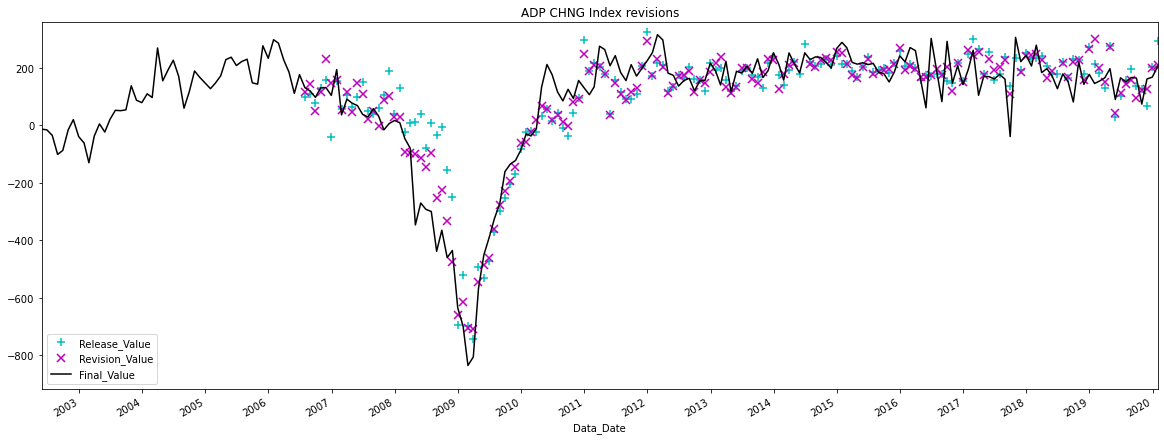

In [19]:
### RUN TO TESTING: FILLED ECO INDICES DATA PLOTTING TO VISUAL CONTROL

### Index choosing:
str_test_index = 'ADP CHNG Index'
### Data loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
### Flags printing:
print(df_flags.loc[str_test_index, All])
### Series creating:
df_eco_ind = df_dates_filled.loc[(str_test_index, All), All].droplevel(0)[['Release_Value', 'Revision_Value', 'Final_Value']]
date_xlim_start = df_eco_ind.index.min()
date_xlim_finish = df_eco_ind.index.max()
#date_xlim_start = datetime(1984, 12, 31)
date_xlim_finish = datetime(2020, 1, 31)
flo_ylim_min = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].min().min()
flo_ylim_max = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].max().max()
tup_ylim = (flo_ylim_min - abs(flo_ylim_min) / 10, flo_ylim_max + abs(flo_ylim_max) / 10)
#ax_eco_ind = df_eco_ind.plot(figsize = (11, 2), title = str_test_index + ' revisions',                              
ax_eco_ind = df_eco_ind.plot(figsize = (20, 7.5), title = str_test_index + ' revisions', 
                style = ['c+', 'mx', 'k-'], markersize = 7.5, markeredgewidth = 1.5, 
                xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim, x_compat = True)
ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))                
plt.show() 

Type_Prime                                                   EMP
Type_Second                                                  Emp
Category                                              Coincident
Region                                                        US
Processing                                                  Flow
Base                                                          -1
SA_Status                                                Unclear
Frequency                                                Monthly
Negative                                                       0
Description    ADP National Employment Report Private Nonfarm...
Data_Source                       Automatic Data Processing, Inc
Notes          This indicator measures the number of employee...
Sub_Type                                                     Emp
Name: ADP CHNG Index, dtype: object


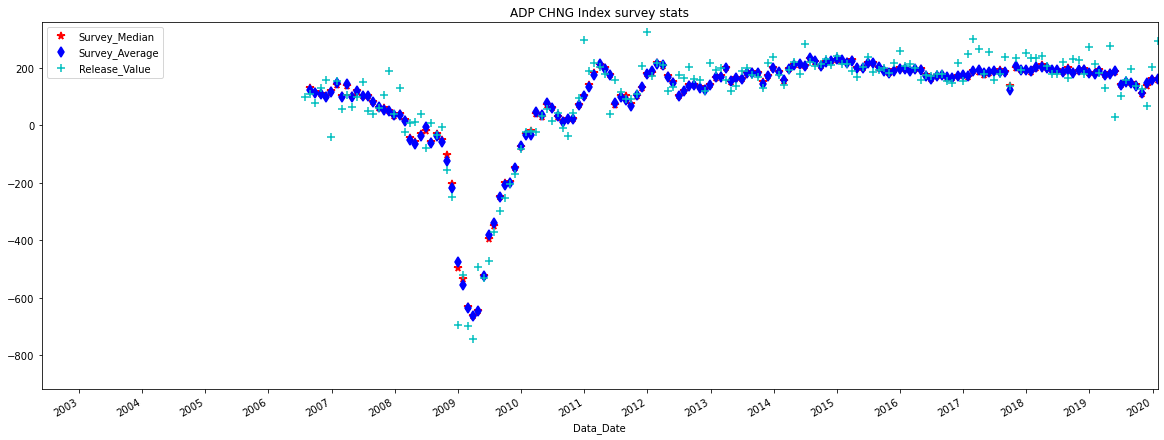

In [20]:
### RUN TO TESTING: FILLED ECO INDICES DATA PLOTTING TO VISUAL CONTROL ### CELL TO ADD

### Index choosing:
str_test_index = 'ADP CHNG Index'
### Data loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
#### Flags printing:
print(df_flags.loc[str_test_index, All])
### Series creating:
if ((len(df_dates_filled.loc[(str_test_index, All), 'Survey_Median'].dropna()) == 0) & 
    (len(df_dates_filled.loc[(str_test_index, All), 'Survey_Average'].dropna()) == 0)):
    print('NO SURVEY DATA HERE!')
df_eco_ind = df_dates_filled.loc[(str_test_index, All), All].droplevel(0)[['Survey_Median', 'Survey_Average', 'Release_Value', 'Revision_Value', 'Final_Value']]    
date_xlim_start = df_eco_ind.index.min()
date_xlim_finish = df_eco_ind.index.max()
#date_xlim_start = datetime(1984, 12, 31)
date_xlim_finish = datetime(2020, 1, 31)
#date_xlim_finish = datetime(2020, 8, 31)
flo_ylim_min = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].min().min()
flo_ylim_max = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].max().max()
tup_ylim = (flo_ylim_min - abs(flo_ylim_min) / 10, flo_ylim_max + abs(flo_ylim_max) / 10)
ax_eco_ind = df_eco_ind[['Survey_Median', 'Survey_Average', 'Release_Value']].plot(figsize = (20, 7.5), title = str_test_index + ' survey stats', 
                style = ['r*', 'bd', 'c+'], markersize = 7.5, markeredgewidth = 1.5, 
                xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim, x_compat = True)
ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))                
plt.show()
#ax_eco_ind = df_eco_ind.plot(figsize = (20, 5), title = str_test_index + ' revisions', 
#                style = ['r*', 'bd', 'c+', 'mx', 'k-'], markersize = 7.5, markeredgewidth = 1.5,                              
#                xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim, x_compat = True)
#ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
#ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))                
#plt.show() 

In [21]:
### RUN TO RE-EXPORT DATA: VALUES STACKING

### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
### Release pair stacking:
df_release_pair = df_dates_filled[['Release_Date', 'Release_Value']]
df_release_pair.columns = ['Observation_Date', 'Index_Value']
df_release_pair = df_release_pair.dropna()
ser_release_based = df_release_pair.set_index('Observation_Date', append = True).squeeze()
#df_release_pair['Stage'] = 'Release'
#ser_release_based = df_release_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### First revision pair stacking:
df_revision_pair = df_dates_filled[['Revision_Date', 'Revision_Value']]
df_revision_pair.columns = ['Observation_Date', 'Index_Value']
df_revision_pair = df_revision_pair.dropna()
ser_revision_based = df_revision_pair.set_index('Observation_Date', append = True).squeeze()
#df_revision_pair['Stage'] = 'First Revision'
#ser_revision_based = df_revision_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### Final revision pair stacking:
df_final_pair = df_dates_filled[['Final_Date', 'Final_Value']]
df_final_pair.columns = ['Observation_Date', 'Index_Value']
df_final_pair = df_final_pair.dropna()
ser_final_based = df_final_pair.set_index('Observation_Date', append = True).squeeze()
#df_final_pair['Stage'] = 'Final Revision'
#ser_final_based = df_final_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### Vectors aggregating:
ser_history_raw = ser_final_based.combine_first(ser_revision_based).combine_first(ser_release_based).dropna().sort_index()

In [22]:
### RUN TO RE-EXPORT DATA: FREQUENCY RECREATING

### 84 : BAKETOT Index frequency recreating:
ser_history_raw.loc['BAKETOT Index', pd.to_datetime('1994-12-23'), pd.to_datetime('1994-12-23')] = np.NaN
ser_history_raw.loc['BAKETOT Index', pd.to_datetime('1995-12-22'), pd.to_datetime('1995-12-22')] = np.NaN
### 87 : ITBCI Index frequency recreating:
ser_history_raw.loc['ITBCI Index', pd.to_datetime('2020-04-30'), pd.to_datetime('2020-04-30')] = np.NaN
### 88 : ITPSSA Index frequency recreating:
ser_history_raw.loc['ITPSSA Index', pd.to_datetime('2020-04-30'), pd.to_datetime('2020-04-30')] = np.NaN
### 89 : JCOMHCF Index frequency recreating:
idx_ticker_date = ser_history_raw.loc[['JCOMHCF Index'], All, All].index.get_level_values('Data_Date').unique()
idx_ticker_date = pd.date_range(start = '1984-12-31', end = '2004-03-31', freq = 'M').difference(idx_ticker_date)
idx_ticker_reindex = pd.MultiIndex.from_tuples(tuple(zip(['JCOMHCF Index'] * len(idx_ticker_date), idx_ticker_date, idx_ticker_date)))
ser_ei_to_add = pd.Series(np.NaN, index = idx_ticker_reindex)
ser_ei_to_add.index.names = ser_history_raw.index.names
ser_history_raw = pd.concat([ser_history_raw, ser_ei_to_add], axis = 0)
### 90 : JNPIY Index frequency rerceating:
ser_history_raw.loc['JNPIY Index', pd.to_datetime('2001-02-28'), pd.to_datetime('2001-02-28')] = np.NaN
### 91 : MAPMINDX Index frequency recreating:
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-05-31'), pd.to_datetime('2016-05-31')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-06-30'), pd.to_datetime('2016-06-30')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-07-31'), pd.to_datetime('2016-07-31')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-08-31'), pd.to_datetime('2016-08-31')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-09-30'), pd.to_datetime('2016-09-30')] = np.NaN
### 92 : MPMIGBMA Index frequency recreating:
idx_ticker_date = pd.date_range(start = '2014-01-31', end = '2015-11-30', freq = 'M')
idx_ticker_reindex = pd.MultiIndex.from_tuples(tuple(zip(['MPMIGBMA Index'] * len(idx_ticker_date), idx_ticker_date, idx_ticker_date)))
ser_ei_to_add = pd.Series(np.NaN, index = idx_ticker_reindex)
ser_ei_to_add.index.names = ser_history_raw.index.names
ser_history_raw = pd.concat([ser_history_raw, ser_ei_to_add], axis = 0)
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2012-05-31'), pd.to_datetime('2012-05-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2013-02-28'), pd.to_datetime('2013-02-28')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-01-31'), pd.to_datetime('2016-01-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-02-29'), pd.to_datetime('2016-02-29')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-06-30'), pd.to_datetime('2016-06-30')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-07-31'), pd.to_datetime('2016-07-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-08-31'), pd.to_datetime('2016-08-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-12-31'), pd.to_datetime('2016-12-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2017-03-31'), pd.to_datetime('2017-03-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2017-04-30'), pd.to_datetime('2017-04-30')] = np.NaN
### 94 : NERS20Y Index frequency recreating:
ser_history_raw.loc['NERS20Y Index', pd.to_datetime('2001-07-31'), pd.to_datetime('2001-07-31')] = np.NaN
### 95 : PTCCI Index frequency recreating:
ser_history_raw.loc['PTCCI Index', pd.to_datetime('2004-05-31'), pd.to_datetime('2004-05-31')] = np.NaN
### 96 : PTCPHAMM Index frequency recreating:
ser_history_raw.loc['PTCPHAMM Index', pd.to_datetime('2019-01-31'), pd.to_datetime('2019-01-31')] = np.NaN
### 97 : UKCCI Index frequency recreating:
ser_history_raw.loc['UKCCI Index', pd.to_datetime('1995-05-31'), pd.to_datetime('1995-05-31')] = np.NaN
### Index sorting:
ser_history_raw = ser_history_raw.sort_index()
### Results saving:
ser_history_raw.to_hdf(str_path_bb_fcast_hdf, key = str_key_raw_history, mode = 'a')

In [23]:
### RUN TO TESTING: FREQUENCY CONTROL

ser_history_raw = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_history)
ser_idx_test = ser_history_raw.to_frame().reset_index('Data_Date')['Data_Date'].squeeze().reset_index('Observation_Date', drop = True)
ser_idx_test = ser_idx_test.groupby('Index_Name', group_keys = False).apply(lambda ser_ticker: ser_ticker.drop_duplicates())
df_idx_test = ser_idx_test.groupby('Index_Name').apply(lambda ser_ticker: (ser_ticker - ser_ticker.shift()).dt.days).groupby('Index_Name')\
                                                .agg(['min', 'max', 'median'])
df_idx_test['delta'] = df_idx_test['max'] - df_idx_test['min']
df_idx_test.sort_values('delta')

,min,max,median,delta
Index_Name,,,,
INJCSP Index,7.0,7.0,7.0,0.0
COMFCOMF Index,7.0,7.0,7.0,0.0
BAKETOT Index,7.0,7.0,7.0,0.0
INJCJC Index,7.0,7.0,7.0,0.0
GDP CQOQ Index,90.0,92.0,91.0,2.0
...,...,...,...,...
IECPEUIQ Index,28.0,31.0,31.0,3.0
IECPIMOM Index,28.0,31.0,31.0,3.0
IECSINDX Index,28.0,31.0,31.0,3.0


In [24]:
### RUN TO RE-EXPORT DATA: HISTORY REINDEXATION TO OBSERVATION DATE BUSINESS DAILY MATRIX STRUCTURE (PRELIMINARY ACTIONS)

### Data loading:
ser_history_raw = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_history)
### Moving all dates to tne nearest Business day:
df_history_raw = ser_history_raw.to_frame().reset_index('Observation_Date')
df_history_raw['Observation_Date'] = df_history_raw['Observation_Date'] + 0 * pd.offsets.BDay()
ser_history_bday = df_history_raw.set_index('Observation_Date', append = True).squeeze()
ser_history_bday = ser_history_bday.loc[All, All, idx_date_range]
### Data adding to hdf collection:
ser_history_bday.to_hdf(str_path_bb_fcast_hdf, key = str_key_bday_history, mode = 'a') ### BDay moved observation dates

In [25]:
### RUN TO RE-EXPORT DATA: GROUPING RESEARCH TO SELECT BASIS TICKERS

### Defining minimum Data Date for each ticker:
ser_history_bday = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_bday_history)
ser_min_date = ser_history_bday.to_frame().reset_index('Data_Date').drop(0, axis = 1).reset_index('Observation_Date', drop = True).squeeze().groupby('Index_Name')\
                                                                                                                                            .agg(min)
ser_min_date.name = 'Min_Date'
ser_max_date = ser_history_bday.to_frame().reset_index('Data_Date').drop(0, axis = 1).reset_index('Observation_Date', drop = True).squeeze().groupby('Index_Name')\
                                                                                                                                            .agg(max)
ser_max_date.name = 'Max_Date'
### Creating description table for all types combinations:
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
### Defining description table generator:
def type_analyzer(df_group):
    ### Type tickers distribution by region calculating:
    ser_cat_distribution = df_group.groupby('Category').apply(lambda df_category: len(df_category.index))
    ser_cat_distribution['All'] = len(df_group.index)
    ser_cat_distribution = pd.concat([ser_cat_distribution], keys = ['Categories_Distrib'], names = ['Info'])
    ### Adding information about basis ticker for each type:
    ser_cat_distribution['Basic_Ticker_Info', 'Basic_Name'] = df_group['Min_Date'].idxmin()
    ser_cat_distribution['Basic_Ticker_Info', 'Category'] = df_group.loc[df_group['Min_Date'].idxmin(), 'Category']
    ser_cat_distribution['Basic_Ticker_Info', 'Min_Date'] = df_group.loc[df_group['Min_Date'].idxmin(), 'Min_Date']    
    ser_cat_distribution['Basic_Ticker_Info', 'Description'] = df_group.loc[df_group['Min_Date'].idxmin(), 'Description']     
    ### Results output:
    return ser_cat_distribution
### Extending flags table and dropping tickers, that were cleared earlier:
df_flags_typed = pd.concat([df_flags, ser_min_date, ser_max_date], axis = 1, sort = False)
df_flags_typed = df_flags_typed.loc[df_flags_typed['Min_Date'].notna()]
### Description table generating:
df_type_info = df_flags_typed.groupby(['Type_Prime', 'Sub_Type', 'Region']).apply(type_analyzer)
df_type_info = df_type_info.unstack(['Info', 'Category'], fill_value = 0)
df_type_info.columns.names = ['', '']
df_type_info = df_type_info.sort_index(axis = 1)
### Description table editing to choose proper basic tickers in some cases:
df_type_info.loc[('ANT', 'Bus', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['EUBCI Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('ANT', 'Bus', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['NAPMPMI Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('ANT', 'Cons', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['EUCCEMU Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('EMP', 'Emp', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['USURTOT Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Orders', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['TMNOCHNG Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Prod', 'Japan'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['JNIPMOM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info[('Basic_Ticker_Info', 'Min_Date')] = pd.to_datetime(df_type_info[('Basic_Ticker_Info', 'Min_Date')])
### Description table additional editing to optimize groups:
df_type_info.loc[('ANT', 'Bus', 'UK'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['ITSR1B Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('CON', 'Cons', 'Japan'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['JNDSTYOY Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('CON', 'Cons', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['PITLCHNG Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('EMP', 'Emp', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['UMRTEMU Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('EMP', 'Emp', 'UK'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['UKUEMOM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('INF', 'CPI', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['ECCPEMUM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('INF', 'CPI', 'UK'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['UKRPXYOY Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('INF', 'CPI', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['PCE CMOM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Orders', 'Japan'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['JNMOCHNG Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Prod', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['EUITEMUM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
## Binding each ticker with it's basis:
df_basic_ticker = df_type_info[[('Basic_Ticker_Info', 'Basic_Name'), ('Basic_Ticker_Info', 'Min_Date')]]
df_basic_ticker.columns = ['Basic_Ticker', 'Basic_Min_Date']
df_flags_typed = df_flags_typed.join(df_basic_ticker, how = 'left', on = ['Type_Prime', 'Sub_Type', 'Region'])
### Clearing basic ticker for basic tickers and resort values to guarantee basic tickers priority:
df_flags_typed.loc[df_flags_typed.index == df_flags_typed['Basic_Ticker'], 'Basic_Ticker'] = ''
df_flags_typed = df_flags_typed.groupby('Basic_Ticker', group_keys = False).apply(lambda df_group: df_group.sort_index())
### Adding flag to define if we need to rebase ticker:
df_flags_typed['Rebase_Flag'] = True
df_flags_typed.loc[df_flags_typed['Basic_Ticker'] == '', 'Rebase_Flag'] = False
df_flags_typed.loc[df_flags_typed['Min_Date'] < (datetime_basis - pd.DateOffset(years = int_not_to_rebase_term)), 'Rebase_Flag'] = False
df_flags_typed.loc[df_flags_typed['Min_Date'] < (df_flags_typed['Basic_Min_Date'] + pd.DateOffset(years = int_not_to_rebase_diff)), 'Rebase_Flag'] = False
### Columns reordering and filtering:
df_flags_typed = df_flags_typed[['Type_Prime', 'Sub_Type', 'Region', 'Category', 'Min_Date', 'Max_Date', 'Frequency', 'Processing', 'Base', 'SA_Status', 'Negative',
                                 'Rebase_Flag', 'Basic_Ticker', 'Description', 'Data_Source', 'Notes']]
df_flags_typed.index.names = ['Index_Name']
### Results saving:
df_type_info.to_hdf(str_path_bb_fcast_hdf, key = str_key_types_info, mode = 'a')
df_flags_typed.to_hdf(str_path_bb_fcast_hdf, key = str_key_flags_typed, mode = 'a')
#df_type_info.to_excel('Data_Files/Test_Files/Ticker_Info.xlsx', merge_cells = False)
#df_flags_typed.to_excel('Data_Files/Test_Files/Ticker_Info.xlsx', merge_cells = False)

In [26]:
### RUN TO RE-EXPORT DATA: REPLACING RELEASE VALUES WITH SURVEY MEDIANS TO NORMALIZE SURVEY MEDIAN BY MATRIX STRUCTURE TRANSFORMATION ### CELL TO ADD

### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
### Data loading:
ser_history_survey = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_history)
### Release pair stacking:
df_release_pair = df_dates_filled[['Release_Date', 'Release_Value']]
df_release_pair.columns = ['Observation_Date', 'Release_Value']
df_release_pair = df_release_pair.dropna()
ser_release_based = df_release_pair.set_index('Observation_Date', append = True).squeeze()

### Survey pair stacking:
df_survey_pair = df_dates_filled[['Release_Date', 'Survey_Median']]
df_survey_pair.columns = ['Observation_Date', 'Index_Value']
df_survey_pair = df_survey_pair.dropna()
ser_survey_based = df_survey_pair.set_index('Observation_Date', append = True).squeeze()
idx_survey_indices = ser_survey_based.index.get_level_values('Index_Name').unique()
ser_survey_based = ser_release_based.to_frame().join(ser_survey_based, how = 'left')['Index_Value']

ser_history_survey.loc[ser_survey_based.index] = ser_survey_based.values
ser_history_survey = ser_history_survey.loc[idx_survey_indices]

ser_history_survey.to_hdf(str_path_bb_fcast_hdf, key = str_key_survey_history, mode = 'a')

In [ ]:
### RUN TO RE-EXPORT DATA: HISTORY DATA TRANSFORMATION (ANTICIPATION ONLY)

gc.collect()
### Defining parallelized transform for groupby groups:
def transformParallel(serGrouped, func):
    retLst = Parallel(n_jobs = 4)(delayed(func)(group) for name, group in serGrouped)    
    return pd.concat(retLst)
### Defining Economic Index series transformation:
def complex_transform(ser_name, idx_date_range, df_flags, int_max_name_length, int_min_years, str_path_bb_matrix_hdf, bool_perform_sa = False):
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        ### Extracting particular Data Date:
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Data_Date')
        ### Filtering over-diagonal values:
        ser_result = ser_result[ser_result.index >= date_diag] 
        ### Results output:
        return ser_result
    ### X13 ARIMA Seasonality adjustment model:
    def perform_x13_sa(ser_date):
        ### Dropping constant level:        
        ser_result = ser_date.droplevel('Observation_Date')
        ### Check for not empty vector:
        if (ser_result.count() > 0):
            ### Check for minimal quantity of observations to perform seasonality adjustment:
            if (ser_result.last_valid_index() - ser_result.first_valid_index()).days >= (int_min_years * 365):   
                ### Naming series for x13 performing:
                ser_result.name = 'Ticker'
                ### Calculating shift value to make all series positive:
                flo_positron = abs(ser_result.min()) * 2
                try:
                    ### Performing seasonality adjustment:
                    ser_result = x13_arima_analysis(ser_result + flo_positron, outlier = True, trading = True).seasadj - flo_positron
#                    print('SA success : ', ser_date.index.get_level_values('Observation_Date')[0])                 
                except:
                    print('SA error : ', ser_date.index.get_level_values('Observation_Date')[0])
                    pass
        ### Results output:                
#        return ser_result 
        return pd.concat([ser_result], keys = [ser_date.index.get_level_values('Observation_Date')[0]], names = ['Observation_Date'])    
    ### Extracting Observation Date column for ticker:
    def get_obs_date_vector(str_ticker, str_path_bb_matrix_hdf, str_date, bool_exact_date = False, bool_drop_levels = True):
        ### Vector for exact date:
        if bool_exact_date:
            ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
        ### Vector for nearest date:        
        else:
            ### Loading full ticker series:        
            ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
            ### Extracting data for max date less or equal to needed date:
            ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
        ### Dropping constant index levels if needed:
        if bool_drop_levels:
            return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
        else:
            return ser_obs_date    
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, 
                        str_path_bb_matrix_hdf, str_basis_index, bool_rebase_flag, list_continue_rebase):
        ### Check for empty vector (doing nothing):
        if ser_date.count():
            ### Check for non-constant vector:
            if (ser_date.std() > flo_tolerance):
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                    ### Calculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                    bool_to_winsor = True   
                    int_iter = 1
                    while (bool_to_winsor): 
                        int_iter += 1                
                        ### Value based winsorization:                
                        ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                        ### Recalculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                        ### Checking for boundaries and steps:
                        if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                            bool_to_winsor = False
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
            else:
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                    ### Constant values demeaning:
                    ser_date = ser_date - ser_date.mean()
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')                    
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date    
    ### EI name extracting:
    str_index_name = ser_name.index.get_level_values(0)[0]
    ### Observation dates reindexation:    
    print(ser_name.index.get_level_values(0)[0], ': Reindexation')    
    idx_observation_range = ser_name.index.get_level_values('Observation_Date').unique().intersection(idx_date_range).sort_values()
    ser_full = ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range).stack('Data_Date', dropna = False).squeeze()
    ser_full = ser_full.swaplevel()
    ser_full.index.rename('Observation_Date', level = -1, inplace = True)    
    ### Forward filling for each data date:
    ser_full = ser_full.groupby('Data_Date').ffill()   
    ### Diagonalization:
    ser_triangle = ser_full.groupby('Data_Date').apply(triangle_filter).sort_index()
    ### Flags extracting:
    ser_flags = df_flags.loc[str_index_name, All].squeeze() 
    ### 'TAR' type checking:
    if (ser_flags['Type_Prime'] == 'TAR'):
        print(str_index_name, ': TAR Primary Type ignoring')        
        pass
    ### Flags-based transforming:
    else:
        ### Indices of NA values collecting:
        idx_isna = ser_triangle.loc[ser_triangle.isna()].index
        ### Transforming to stock-like series:
        ser_stock = ser_triangle
        ### Seasonality adjustment:
        if (bool_perform_sa & (ser_flags['SA_Status'].strip(' ') != 'SA')):
            print(str_index_name, ': Seasonality adjustment')            
            ### Filling empty values:            
            ser_stock = ser_stock.groupby('Observation_Date').ffill()
#            ser_stock = ser_stock.groupby('Observation_Date').apply(perform_x13_sa).swaplevel().sort_index()
            ser_stock = transformParallel(ser_stock.groupby('Observation_Date'), perform_x13_sa).swaplevel().sort_index()       
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN    
        ### Debasing:
        print(str_index_name, ': Debasing')            
        ser_ant = ser_stock - ser_flags['Base']           
        ser_ant.name = 'MoM'
        ### Negative flag check:
        if (ser_flags['Negative'] == 1):
            ser_ant = -ser_ant
        ### Z-scoring across the observation dates:
        print(ser_name.index.get_level_values(0)[0], ': Z-scoring across the observation dates')
        ### To stop rebasing when basic ticker (std, mean) are close to (1, 0):
        list_continue_rebase = [True] 
        ### Adjusting Z-score period limit for some groups:
        if (ser_flags['Data_Source'] == 'Markit'):
            int_min_years_adj = int_min_years - 1
        else:
            int_min_years_adj = int_min_years    
        ### Z-score tranformation:
        ser_ant_z = ser_ant.groupby('Observation_Date')\
                           .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_adj,
                                      str_path_bb_matrix_hdf, ser_flags['Basic_Ticker'], ser_flags['Rebase_Flag'], list_continue_rebase)       
        ### Adding results to matrix cube:
        pd.concat([ser_ant_z], keys = [str_index_name], names = ['Index_Name']).to_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, format = 'table',
                                                                                       complevel = 9, append = True, mode = 'a',
                                                                                       min_itemsize = {'Index_Name': int_max_name_length})    
#    ### Results output:
#    return pd.concat([ser_mom_z], keys = [str_index_name], names = ['Index_Name'])

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags_typed)
df_flags_ant = df_flags_typed[(df_flags_typed['Type_Prime'] == 'ANT') & (df_flags_typed['Processing'] == 'Index')]
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_survey_history)
ser_history_ant = ser_history_bday.reindex(df_flags_ant.index, level = 'Index_Name')
### Previous HDF file deleting:
if os.path.isfile(str_path_survey_matrix_ant_hdf):
    os.remove(str_path_survey_matrix_ant_hdf)
### Maximum length calculating (for HDF manipulations):
int_max_name_length = max(ser_history_ant.index.levels[0].str.len())
### Data transforming:
ser_history_ant.groupby('Index_Name').apply(complex_transform, idx_date_range, df_flags_typed, int_max_name_length, int_min_years_z_score, 
                                            str_path_survey_matrix_ant_hdf, bool_perform_sa = True)

In [ ]:
### RUN TO RE-EXPORT DATA: HISTORY DATA TRANSFORMATION (YOY ONLY)

### Defining parallelized transform for groupby groups:
def transformParallel(serGrouped, func):
    retLst = Parallel(n_jobs = 4)(delayed(func)(group) for name, group in serGrouped)    
    return pd.concat(retLst)
### Defining Economic Index series transformation:
def complex_transform(ser_name, idx_date_range, df_flags, int_max_name_length, int_min_years, str_path_bb_matrix_hdf, bool_perform_sa = False):
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        ### Extracting particular Data Date:
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Data_Date')
        ### Filtering over-diagonal values:
        ser_result = ser_result[ser_result.index >= date_diag] 
        ### Results output:
        return ser_result
    ### Period-over-period-percent ticker values transforming to stock-like series:
    def pop_to_level(ser_date, int_step):
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Observation_Date')
        ### Basis initiating:
        flo_basement = 1.0
        ### Factor initiating: 
        flo_next_brick  = 1.0
        ### Looping over month numbers:
        for iter_period in range(min(int_step, len(ser_result.index))):         
            ### Basement building up:
            flo_basement = flo_basement * flo_next_brick
            ### Next basement brick producing:
            flo_next_brick = ((flo_next_brick ** (iter_period)) * (ser_result.iloc[iter_period] ** (1 / int_step))) ** (1 / (iter_period + 1)) 
            ### Jumping cumulative product performing:
            idx_iter_data = ser_result.index[iter_period :: int_step]
            ser_result.loc[idx_iter_data] = ser_result.loc[idx_iter_data].cumprod() * flo_basement       
        ### Results output:            
        return ser_result    
    ### X13 ARIMA Seasonality adjustment model:
    def perform_x13_sa(ser_date):
        ### Dropping constant level:        
        ser_result = ser_date.droplevel('Observation_Date')
        ### Check for not empty vector:
        if (ser_result.count() > 0):
            ### Check for minimal quantity of observations to perform seasonality adjustment:
            if (ser_result.last_valid_index() - ser_result.first_valid_index()).days >= (int_min_years * 365):   
                ### Naming series for x13 performing:
                ser_result.name = 'Ticker'
                ### Calculating shift value to make all series positive:
                flo_positron = abs(ser_result.min()) * 2
                try:
                    ### Performing seasonality adjustment:
                    ser_result = x13_arima_analysis(ser_result + flo_positron, outlier = True, trading = True).seasadj - flo_positron
#                    print('SA success : ', ser_date.index.get_level_values('Observation_Date')[0])                 
                except:
                    print('SA error : ', ser_date.index.get_level_values('Observation_Date')[0])
                    pass
        ### Results output:                
#        return ser_result 
        return pd.concat([ser_result], keys = [ser_date.index.get_level_values('Observation_Date')[0]], names = ['Observation_Date'])    
    ### Extracting Observation Date column for ticker:
    def get_obs_date_vector(str_ticker, str_path_bb_matrix_hdf, str_date, bool_exact_date = False, bool_drop_levels = True):
        ### Vector for exact date:
        if bool_exact_date:
            ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
        ### Vector for nearest date:        
        else:
            ### Loading full ticker series:        
            ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
            ### Extracting data for max date less or equal to needed date:
            ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
        ### Dropping constant index levels if needed:
        if bool_drop_levels:
            return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
        else:
            return ser_obs_date    
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, 
                        str_path_bb_matrix_hdf, str_basis_index, bool_rebase_flag, list_continue_rebase):
        ### Check for empty vector (doing nothing):
        if ser_date.count():
            ### Check for non-constant vector:
            if (ser_date.std() > flo_tolerance):
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                    ### Calculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                    bool_to_winsor = True   
                    int_iter = 1
                    while (bool_to_winsor): 
                        int_iter += 1                
                        ### Value based winsorization:                
                        ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                        ### Recalculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                        ### Checking for boundaries and steps:
                        if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                            bool_to_winsor = False
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
            else:
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                    ### Constant values demeaning:
                    ser_date = ser_date - ser_date.mean()
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')                    
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date    
    ### EI name extracting:
    str_index_name = ser_name.index.get_level_values(0)[0]
    ### Observation dates reindexation:    
    print(ser_name.index.get_level_values(0)[0], ': Reindexation')    
    idx_observation_range = ser_name.index.get_level_values('Observation_Date').unique().intersection(idx_date_range).sort_values()
    ser_full = ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range).stack('Data_Date', dropna = False).squeeze()
    ser_full = ser_full.swaplevel()
    ser_full.index.rename('Observation_Date', level = -1, inplace = True)    
    ### Forward filling for each data date:
    ser_full = ser_full.groupby('Data_Date').ffill()   
    ### Diagonalization:
    ser_triangle = ser_full.groupby('Data_Date').apply(triangle_filter).sort_index()
    ### Flags extracting:
    ser_flags = df_flags.loc[str_index_name, All].squeeze() 
    ### 'TAR' type checking:
    if (ser_flags['Type_Prime'] == 'TAR'):
        print(str_index_name, ': TAR Primary Type ignoring')        
        pass
    ### Flags-based transforming:
    else:
        ### Indices of NA values collecting:
        idx_isna = ser_triangle.loc[ser_triangle.isna()].index
        ### Transforming to stock-like series:
        if (ser_flags['Processing'] in ['Index', 'Level', 'Level%']):
            ser_stock = ser_triangle
        elif (ser_flags['Processing'] == 'Flow'):
            print(str_index_name, ': Transformation to stock-like series: Cumulative sum')
            ### Filling empty values:
            ser_triangle = ser_triangle.fillna(0)
            ### Cumulative sum for each observation date calculating:
            ser_stock = ser_triangle.groupby('Observation_Date').cumsum()
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN
        else:
            print(str_index_name, ': Transformation to stock-like series: Cumulative product')
            ### Filling empty values:
            ser_triangle = ser_triangle.fillna(0)
            ### Percents to multipliers converting:
            ser_stock = 1 + ser_triangle / 100
            ### Calculating with needed periodicity:
            if (ser_flags['Frequency'] == 'Monthly'):
                int_step = dict_cumprod_step[ser_flags['Processing']]
                ### Period-by-period cumprod with rebasing:
                ser_stock = ser_stock.groupby('Observation_Date').apply(pop_to_level, int_step).swaplevel().sort_index()
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN
        ### Seasonality adjustment:
        if (bool_perform_sa & (ser_flags['SA_Status'].strip(' ') != 'SA')):
            print(str_index_name, ': Seasonality adjustment')            
            ### Filling empty values:            
            ser_stock = ser_stock.groupby('Observation_Date').ffill()
#            ser_stock = ser_stock.groupby('Observation_Date').apply(perform_x13_sa).swaplevel().sort_index()
            ser_stock = transformParallel(ser_stock.groupby('Observation_Date'), perform_x13_sa).swaplevel().sort_index()       
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN    
        ### Transforming to PoP series:
        if (ser_flags['Processing'] == 'Index'):
            ### Debasing only:
            print(str_index_name, ': Transformation to YoY series: Debasing')            
            ser_ant = ser_stock - ser_flags['Base']           
        elif (ser_flags['Processing'] in ['Flow', 'Level']):    
            ### Simple difference:
            print(str_index_name, ': Transformation to YoY series: Simple difference')
            ### Shifting lag defining:
            if (ser_flags['Frequency'] in dict_yoy_shift.keys()):
                int_yoy_shift = dict_yoy_shift[ser_flags['Frequency']]
            else:
                int_yoy_shift = dict_yoy_shift['Other']            
            ### Stock-like series differing:
            ser_yoy = ser_stock.groupby('Observation_Date', group_keys = False).apply(lambda ser_obs_date: ser_obs_date - ser_obs_date.shift(int_yoy_shift))
        else:      
            ### Difference with dividing:
            print(str_index_name, ': Transformation to YoY series: Difference with dividing')
            ### Shifting lag defining:
            if (ser_flags['Frequency'] in dict_yoy_shift.keys()):
                int_yoy_shift = dict_yoy_shift[ser_flags['Frequency']]
            else:
                int_yoy_shift = dict_yoy_shift['Other']
            ### Stock-like series differing:
            ser_yoy = ser_stock.groupby('Observation_Date', group_keys = False)\
                               .apply(lambda ser_obs_date: (ser_obs_date / ser_obs_date.shift(int_yoy_shift) - 1))  
        ser_yoy.name = 'YoY'
        ### Negative flag check:
        if (ser_flags['Negative'] == 1):
            ser_yoy = -ser_yoy
        ### Z-scoring across the observation dates:
        print(ser_name.index.get_level_values(0)[0], ': Z-scoring across the observation dates')
        ### To stop rebasing when basic ticker (std, mean) are close to (1, 0):
        list_continue_rebase = [True] 
        ### Adjusting Z-score period limit for some groups:
        if (ser_flags['Data_Source'] == 'Markit'):
            int_min_years_adj = int_min_years - 1
        else:
            int_min_years_adj = int_min_years    
        ### Z-score tranformation:
        ser_yoy_z = ser_yoy.groupby('Observation_Date')\
                           .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_adj,
                                      str_path_bb_matrix_hdf, ser_flags['Basic_Ticker'], ser_flags['Rebase_Flag'], list_continue_rebase)       
#        ser_yoy_z = transformParallel(ser_yoy.groupby('Observation_Date'), by_date_z_score_to_parallel).sort_index() ### Parallelization attempt
        ### Adding results to matrix cube:
        pd.concat([ser_yoy_z], keys = [str_index_name], names = ['Index_Name']).to_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, format = 'table',
                                                                                       complevel = 9, append = True, mode = 'a',
                                                                                       min_itemsize = {'Index_Name': int_max_name_length})    
#    ### Results output:
#    return pd.concat([ser_yoy_z], keys = [str_index_name], names = ['Index_Name'])

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags_typed)
df_flags_other = df_flags_typed[(df_flags_typed['Type_Prime'] != 'ANT') & (df_flags_typed['Processing'] != 'Index')]
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_survey_history)
ser_history_other = ser_history_bday.reindex(df_flags_other.index, level = 'Index_Name')#.loc[['GRFRIAMM Index', 'ITVHYOY Index', 'NERS20Y Index'], All, All]
### Previous HDF file deleting:
if os.path.isfile(str_path_survey_matrix_yoy_hdf):
    os.remove(str_path_survey_matrix_yoy_hdf)
### Maximum length calculating (for HDF manipulations):
int_max_name_length = max(ser_history_other.index.levels[0].str.len())
### Data transforming:
ser_history_other.groupby('Index_Name').apply(complex_transform, idx_date_range, df_flags_typed, int_max_name_length, int_min_years_z_score, 
                                              str_path_survey_matrix_yoy_hdf, bool_perform_sa = True)

In [ ]:
### EXTRACTION OF NORMALIZED MATRIX DATA TO REPLACE ORIGINAL VALUES

### Defining values extraction process:
def get_normalized_ticker(df_ticker_to_change):
    ### Ticker name taking:
    str_ticker = df_ticker_to_change.index[0][0]
    print(str_ticker)
    df_ticker_to_change = df_ticker_to_change.droplevel('Index_Name')
    ### Extracting normalized data from matrices:
    if (df_flags_typed.loc[str_ticker, 'Type_Prime'] == 'ANT'):        
        ser_normalized_release = pd.read_hdf(str_path_bb_matrix_ant_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker').droplevel('Index_Name')
        ser_normalized_survey = pd.read_hdf(str_path_survey_matrix_ant_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker').droplevel('Index_Name')
    else:
        ser_normalized_release = pd.read_hdf(str_path_bb_matrix_yoy_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker').droplevel('Index_Name')
        ser_normalized_survey = pd.read_hdf(str_path_survey_matrix_yoy_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker').droplevel('Index_Name')        
    ser_normalized_release.name = 'Normalized_Value'
    ### Release values replacing:
    ser_release = df_ticker_to_change[['Release_Date', 'Release_Value']].set_index('Release_Date', append = True).squeeze()
    ser_release = ser_normalized_release.reindex(ser_release.index)
    ser_release.name = 'Release_Value'
    ### Revision values replacing:    
    ser_revision = df_ticker_to_change[['Revision_Date', 'Revision_Value']].set_index('Revision_Date', append = True).squeeze()
    ser_revision = ser_normalized_release.reindex(ser_revision.index)
    ser_revision.name = 'Revision_Value'
    ### Final values replacing:
    ser_final = df_ticker_to_change[['Final_Date', 'Final_Value']].set_index('Final_Date', append = True).squeeze()
    ser_final = ser_normalized_release.reindex(ser_final.index)
    ser_final.name = 'Final_Value'    
    ### Survey Median values replacing:
    ser_survey = df_ticker_to_change[['Release_Date', 'Survey_Median']].set_index('Release_Date', append = True).squeeze()
    ser_survey = ser_normalized_survey.reindex(ser_survey.index)
    ser_survey.name = 'Survey_Median'    
    ### Transformed ticker data preparation:
    df_ticker_normalized = df_ticker_to_change[:]
    df_ticker_normalized['Release_Value'] = ser_release.values
    df_ticker_normalized['Revision_Value'] = ser_revision.values
    df_ticker_normalized['Final_Value'] = ser_final.values
    df_ticker_normalized['Survey_Median'] = ser_survey.values
    ### Results output:
    return df_ticker_normalized

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags_typed)
### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
### Normalized data extraction from matrices:
df_normalized = df_dates_filled.groupby('Index_Name').apply(get_normalized_ticker)
### Results saving:
df_normalized.to_hdf(str_path_bb_fcast_hdf, key = str_key_norm_filled)

In [11]:
### RUN TO RE-EXPORT DATA: TICKERS FILTERING DUE TO TYPE AND SURVEY DATA QUALITY

### Empty revisions filling procedure:
def fill_empty_revision(df_ticker):
    str_ticker_name = df_ticker.index[0][0]
    df_filled = df_ticker.droplevel('Index_Name')
    if (str_ticker_name in idx_to_fill_empty_revision):
        ser_count_nans = df_filled['Revision_Value'].isna().astype(int).groupby(df_filled['Revision_Value'].notna().astype(int).cumsum()).cumsum()
        idx_nans_to_fill = ser_count_nans[(ser_count_nans > 0) & (ser_count_nans <= 2)].index
        df_filled.loc[idx_nans_to_fill, 'Revision_Value'] = df_filled.loc[idx_nans_to_fill, 'Release_Value']    
    return df_filled
### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_norm_filled)
### Types and region export:
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
df_group_info = df_flags[['Type_Prime', 'Sub_Type', 'Region']].copy()
df_group_info['Type'] = df_group_info['Type_Prime'] + '/' + df_group_info['Sub_Type']
df_forecast_data = df_dates_filled.join(df_group_info, how = 'left')
### Dropping EI's having wrong Primary Types:
#df_forecast_data.drop(df_forecast_data[df_forecast_data['Type_Prime'].isin(['TAR', 'INF'])].index, inplace = True)
df_forecast_data = df_forecast_data[df_forecast_data['Type_Prime'] != 'TAR']
### Survey data stats:
print('Observations having Survey Median values:', round(df_forecast_data['Survey_Median'].count() / len(df_forecast_data.index), 4))
print('Observations having Survey Average values:', round(df_forecast_data['Survey_Average'].count() / len(df_forecast_data.index), 4))
print('Observations having neither Survey Median nor Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].isna() & df_forecast_data['Survey_Average'].isna()].index) / len(df_forecast_data.index), 4))
print('Observations having both Survey Median & Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & df_forecast_data['Survey_Average'].notna()].index) / len(df_forecast_data.index), 4))
print('Observations having only Survey Median values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & df_forecast_data['Survey_Average'].isna()].index) / len(df_forecast_data.index), 4))
print('Observations having only Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].isna() & df_forecast_data['Survey_Average'].notna()].index) / len(df_forecast_data.index), 4))
### Dropping rows doesn't have enough data:
df_forecast_data = df_forecast_data[['Release_Date', 'Release_Value', 'Revision_Value', 'Survey_Median', 'Forecast_Std', 'Observations_Number', 'Region', 'Type']]\
                                  .dropna(subset = ['Release_Date'])
### Dates arranging:
df_forecast_data['Release_Date'] = df_forecast_data['Release_Date'] + 0 * pd.offsets.BDay()
df_forecast_data = df_forecast_data[df_forecast_data['Release_Date'] <= datetime_end]
df_forecast_data = df_forecast_data.reset_index('Data_Date', drop = True).set_index('Release_Date', append = True).sort_index()
### Duplicated observations removal (2 * 14):
df_forecast_data = df_forecast_data[~df_forecast_data.index.duplicated(keep = 'last')]
### Wrong observation number rows marking:
print('Observations with incorrect forecasters number values (NaN, 0, 1, 2):', 
      round(len(df_forecast_data[df_forecast_data['Observations_Number'].isna() | df_forecast_data['Observations_Number'].isin([0, 1, 2])].index) / 
            len(df_forecast_data.index), 4))
#df_forecast_data['Observations_Number'].replace({np.NaN: -1, 0: -1, 1: -1, 2: -1}, inplace = True)
idx_changed_to_three = df_forecast_data[df_forecast_data['Observations_Number'].isna() | df_forecast_data['Observations_Number'].isin([0, 1, 2])].index
df_forecast_data['Observations_Number'].replace({np.NaN: 3, 0: 3, 1: 3, 2: 3}, inplace = True)
print('Weight, added by observation numbers replace:', 
      round(np.sqrt(df_forecast_data.loc[idx_changed_to_three, 'Observations_Number']).sum() / np.sqrt(df_forecast_data['Observations_Number']).sum(), 2))
print('Observations with incorrect forecasters number values having forecast std value:', 
      round(len(df_forecast_data[df_forecast_data['Forecast_Std'].notna() & (df_forecast_data['Observations_Number'] == -1)].index) / len(df_forecast_data.index), 4))
print('Observations with incorrect forecasters number values having survey median value:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & (df_forecast_data['Observations_Number'] == -1)].index) / len(df_forecast_data.index), 4))
### Empty revisions filling procedure:
df_forecast_data = df_forecast_data.groupby('Index_Name').apply(fill_empty_revision)
### Adding previous data date values to future Revision Surprise calculation:
df_forecast_data['Release_Prev'] = df_forecast_data['Release_Value'].groupby('Index_Name').shift()
df_forecast_data['Revision_Prev'] = df_forecast_data['Revision_Value'].groupby('Index_Name').shift()
df_forecast_data.drop('Revision_Value', axis = 1, inplace = True)
### Tickers data reindexation to common timeline:
idx_dates = sorted(df_forecast_data.index.get_level_values('Release_Date').unique())
df_reindexed = df_forecast_data.groupby('Index_Name').apply(lambda df_ticker: df_ticker.droplevel('Index_Name').reindex(idx_dates, method = 'ffill'))
### Clearing rows having incorrect data:
#df_cleared = df_reindexed[df_reindexed['Observations_Number'] > -1].copy().dropna(subset = ['Forecast_Std'])
df_cleared = df_reindexed.dropna(how = 'all')
print('Economic indices left to forecast indices generation:', len(df_cleared.index.get_level_values('Index_Name').unique()))
### Cleared and reindexed table saving:
df_cleared.to_hdf(str_path_bb_fcast_hdf, key = str_key_cleared, mode = 'a')
_ = gc.collect()

Observations having Survey Median values: 0.3572
Observations having Survey Average values: 0.3924
Observations having neither Survey Median nor Survey Average values: 0.6
Observations having both Survey Median & Survey Average values: 0.3496
Observations having only Survey Median values: 0.0076
Observations having only Survey Average values: 0.0429
Observations with incorrect forecasters number values (NaN, 0, 1, 2): 0.3844
Weight, added by observation numbers replace: 0.18
Observations with incorrect forecasters number values having forecast std value: 0.0
Observations with incorrect forecasters number values having survey median value: 0.0
Economic indices left to forecast indices generation: 202


In [12]:
### RUN TO TEST: SOURCE DATASETS FOR FORECASTS FACTORS COMPARISION

df_cleared_matrix = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_cleared, mode = 'a')
df_cleared_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_cleared, mode = 'a')
set_matrix = set(df_cleared_matrix.index.get_level_values('Index_Name').unique())
set_std = set(df_cleared_std.index.get_level_values('Index_Name').unique())
print(len(set_std))
print(len(set_matrix))
print(set_std - set_matrix)
print(set_matrix - set_std)

161
202
set()
{'JNCVSSY Index', 'JCOMACF Index', 'JWEXOVRL Index', 'GRCP2BVM Index', 'JCPNEFEY Index', 'SLIOINMM Index', 'GRCP2SAM Index', 'JCPTEFEY Index', 'JNSMTYOY Index', 'SVRTRMOM Index', 'JCOMHCF Index', 'PPI CHNG Index', 'ITVHYOY Index', 'ESPPIMOM Index', 'PTCIEC Index', 'JWCOOVRL Index', 'GRCP2NRM Index', 'PTPPMOM Index', 'JNDSTYOY Index', 'JNMTOY Index', 'ATIPIMM Index', 'GRCP2HEM Index', 'IECSINDX Index', 'FIRSVYOY Index', 'SVIPTMOM Index', 'IEUERT Index', 'PTCCI Index', 'GRCP2BWM Index', 'ESUERR Index', 'PTRTIMOM Index', 'UKVHRYY Index', 'ASPPIMOM Index', 'BEUER Index', 'SVPPIMOM Index', 'MPMIJPCA Index', 'GRCP2BRM Index', 'MAPMINDX Index', 'GKUERATE Index', 'SVBTSI Index', 'BECCN Index', 'EUCPTSAM Index'}


In [13]:
### RUN TO TESTING: GLOBAL INDICES REGION / TYPE STATS

### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
### Tickers register extracting:
ser_ei_data = df_dates_filled.groupby('Index_Name', group_keys = False).apply(lambda df_group: df_group[: 1].droplevel('Data_Date'))['Observations_Number']
### Types and region export and clearing:
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
df_group_info = df_flags.loc[df_flags['Type_Prime'] != 'TAR', ['Type_Prime', 'Sub_Type', 'Region']].copy()
df_group_info['Type'] = df_group_info['Type_Prime'] + '/' + df_group_info['Sub_Type']
df_ei_data = ser_ei_data.to_frame().join(df_group_info, how = 'left')
df_ei_data = df_ei_data[['Type', 'Region']].dropna()
### Economic Indices base pivot table constructing:
df_ei_pivot = df_ei_data.reset_index().set_index(['Type', 'Region']).groupby(['Type', 'Region']).count().unstack('Region').fillna(0)
df_ei_pivot.columns = df_ei_pivot.columns.levels[1]
df_ei_pivot['World'] = df_ei_pivot.sum(axis = 1)
df_ei_pivot.loc['Total'] = df_ei_pivot.sum(axis = 0)
df_ei_pivot = df_ei_pivot.astype(int)
display(df_ei_pivot)
#df_ei_pivot.to_excel('Data_Files/Test_Files/Some_Stats.xlsx', merge_cells = False)

Region,Europe,Japan,UK,US,World
Type,,,,,
ANT/Bus,25,1,7,8,41
ANT/Cons,6,2,1,3,12
ANT/Eco,5,3,0,0,8
CON/Cons,10,6,4,5,25
EMP/Emp,10,2,4,7,23
INF/CPI,32,6,5,3,46
INF/PPI,12,1,3,2,18
OUT/Orders,3,3,0,3,9
OUT/Prod,14,6,3,5,28


In [14]:
### RUN TO TESTING: SURPRISE FACTOR TICKERS DATA REGION / TYPE STATS

### Forecast data loading:
df_cleared = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_cleared)
### Forecast base pivot table constructing:
df_survey_pivot = df_cleared.dropna(subset = ['Type', 'Region']).groupby('Index_Name', group_keys = False)\
                            .apply(lambda df_group: df_group[: 1].droplevel('Release_Date'))[['Type', 'Region']]\
                            .reset_index().set_index(['Type', 'Region']).groupby(['Type', 'Region']).count().unstack('Region').fillna(0)
df_survey_pivot.columns = df_survey_pivot.columns.levels[1]
df_survey_pivot['World'] = df_survey_pivot.sum(axis = 1)
df_survey_pivot.loc['Total'] = df_survey_pivot.sum(axis = 0)
df_survey_pivot = df_survey_pivot.astype(int)
display(df_survey_pivot)
### Pivot tables comparision:
df_survey_comparision = df_survey_pivot.astype(str) + ' (' + df_ei_pivot.astype(str) + ')'
display(df_survey_comparision)
#df_survey_comparision.to_excel('Data_Files/Test_Files/Some_Stats.xlsx', merge_cells = False)

Region,Europe,Japan,UK,US,World
Type,,,,,
ANT/Bus,25,1,5,8,39
ANT/Cons,6,2,1,3,12
ANT/Eco,5,3,0,0,8
CON/Cons,9,5,4,4,22
EMP/Emp,9,2,4,7,22
INF/CPI,31,6,5,3,45
INF/PPI,12,1,3,2,18
OUT/Orders,3,3,0,3,9
OUT/Prod,14,5,3,5,27


Region,Europe,Japan,UK,US,World
Type,,,,,
ANT/Bus,25 (25),1 (1),5 (7),8 (8),39 (41)
ANT/Cons,6 (6),2 (2),1 (1),3 (3),12 (12)
ANT/Eco,5 (5),3 (3),0 (0),0 (0),8 (8)
CON/Cons,9 (10),5 (6),4 (4),4 (5),22 (25)
EMP/Emp,9 (10),2 (2),4 (4),7 (7),22 (23)
INF/CPI,31 (32),6 (6),5 (5),3 (3),45 (46)
INF/PPI,12 (12),1 (1),3 (3),2 (2),18 (18)
OUT/Orders,3 (3),3 (3),0 (0),3 (3),9 (9)
OUT/Prod,14 (14),5 (6),3 (3),5 (5),27 (28)


In [15]:
### RUN TO RE-EXPORT DATA: SETTING TICKER/DATA PAIR WEIGHTS

### Forecast data loading:
df_cleared = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_cleared)
df_cleared['Observations_Number'] = df_cleared['Observations_Number'].astype(int)
### Resampling to business daily frequency without gaps:
df_cleared = df_cleared.unstack('Index_Name').resample('B').asfreq().stack('Index_Name', dropna = False).swaplevel().sort_index()
### Adding rolling mean of obseravtions number:
df_cleared['Rolling_Obs_Number'] = df_cleared['Observations_Number'].unstack('Index_Name').sort_index().rolling(window = int_obs_num_win, min_periods = 1)\
                                                                    .mean().round(0).stack('Index_Name', dropna = False).swaplevel().sort_index()
### Dropping NA values (we need it only to correct rolling mean calculation):
df_weighted = df_cleared.dropna(subset = ['Region', 'Type']).drop('Observations_Number', axis = 1)
### Setting initial weight by square root of observations number:
df_weighted['Obs_Num_Weight'] = df_weighted.groupby(['Release_Date', 'Region', 'Type'])['Rolling_Obs_Number']\
                                           .apply(lambda ser_group: np.sqrt(ser_group) / np.sqrt(ser_group).sum())
### Extracting existing Date / Type / Region combinations:
ser_region_count = df_weighted.groupby(['Release_Date', 'Type', 'Region'])['Type'].count()
ser_region_count = ser_region_count / ser_region_count
ser_region_count.name = 'Group_Flag'
### Region weights preparing:
ser_region_weight = pd.DataFrame.from_dict(dict_region_weight, orient = 'index').squeeze()
ser_region_weight.name = 'Region_Weight'
### Adding region weights to combinations collection:
df_region_weight = ser_region_count.to_frame().join(ser_region_weight, how = 'left', on = 'Region')
### Region weights normalizing:
df_region_weight['Reg_Norm_Weight'] = df_region_weight.groupby(['Release_Date', 'Type'])['Region_Weight'].transform(lambda ser_group: ser_group / ser_group.sum())
### Adding normalized weights to main table:
df_weighted = df_weighted.join(df_region_weight['Reg_Norm_Weight'], how = 'left', on = ['Release_Date', 'Type', 'Region'])
### Adding Growth Index flag:
df_weighted['Growth'] = True
df_weighted.loc[df_weighted['Type'].isin(['INF/CPI', 'INF/PPI']), 'Growth'] = False
### Extracting existing Date / Type combinations:
ser_type_count = df_weighted.groupby(['Release_Date', 'Type'])['Type'].count()
ser_type_count = ser_type_count / ser_type_count
ser_type_count.name = 'Type_Flag'
### FPC weights export:
ser_fpc_weight = pd.read_hdf(str_path_fpc_hdf, key = str_weights_key).stack(dropna = False).swaplevel()
ser_fpc_weight.index.names = ['Type', 'Release_Date']
ser_fpc_weight.name = 'FPC_Weight'
### Adding region weights to combinations collection:
df_type_weight = ser_type_count.to_frame().join(ser_fpc_weight, how = 'left', on = ['Type', 'Release_Date'])
df_type_weight.loc[(All, ['INF/CPI', 'INF/PPI']), 'FPC_Weight'] = 0.5
### Adding Growth Index flag:
df_type_weight['Growth'] = True
df_type_weight.loc[(All, ['INF/CPI', 'INF/PPI']), 'Growth'] = False
### Type weights normalizing:
df_type_weight['Type_Norm_Weight'] = df_type_weight.groupby(['Release_Date', 'Growth'])['FPC_Weight'].transform(lambda ser_group: ser_group / ser_group.sum())
### Filling dates with empty FPC weights (3 dates filled):
df_type_weight['Type_Norm_Weight'] = df_type_weight['Type_Norm_Weight'].groupby('Type').ffill()
### Adding normalized weights to main table:
df_weighted = df_weighted.join(df_type_weight['Type_Norm_Weight'], how = 'left', on = ['Release_Date', 'Type'])
### Ticker weights calculating for each date / ticker pair:
df_weighted['Ticker_Weight'] = df_weighted['Obs_Num_Weight'] * df_weighted['Reg_Norm_Weight'] * df_weighted['Type_Norm_Weight']
### Table saving:
df_weighted[['Release_Value', 'Survey_Median', 'Forecast_Std', 'Rolling_Obs_Number', 'Ticker_Weight', 'Growth', 'Release_Prev', 'Revision_Prev']]\
           .to_hdf(str_path_bb_fcast_hdf, key = str_key_weighted, mode = 'a')

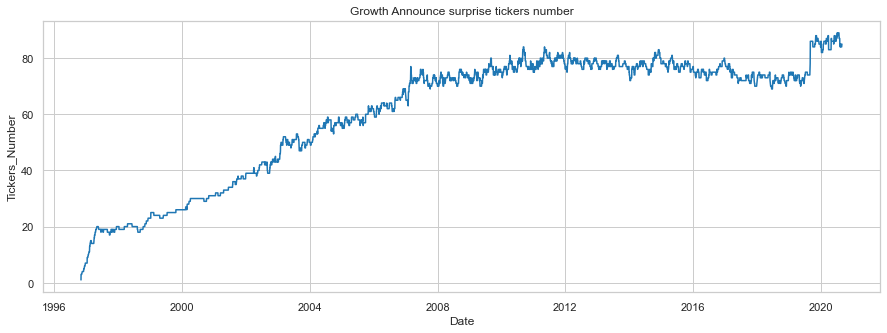

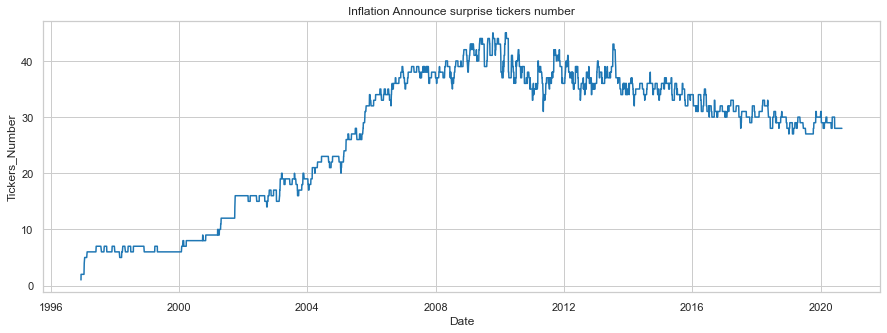

In [16]:
### RUN TO TEST: ANNOUNCE SURPRISE TICKERS NUMBER RESEARCH

### Defining index vector average calculator:
def release_date_surprise_count(df_date, int_min_tickers_to_go):
    ser_date_surprise = (df_date['Release_Value'] - df_date['Survey_Median'])
    return ser_date_surprise.count()
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
### Dropping zero stdev values:
df_surprise.loc[df_surprise['Forecast_Std'] < flo_winsorize_tolerance, 'Forecast_Std'] = np.NaN
### Data dividing:
dict_weighted = {}
dict_weighted['Growth'] = df_surprise[df_surprise['Growth'] == True]
dict_weighted['Inflation'] = df_surprise[df_surprise['Growth'] == False]
### Factors calculating:
dict_surprise = {}
for iter_key in dict_weighted:
    ser_surprise = dict_weighted[iter_key].dropna(how = 'all').groupby('Release_Date').apply(release_date_surprise_count, int_min_tickers_to_go)
    ser_surprise.index.name = 'Date'
    ser_surprise.name = 'Tickers_Number'
    ### Plot creation:
    sns.set_style('whitegrid')
    plt.figure(figsize = (15, 5))
    sns.set_context('notebook') 
    df_to_plot = ser_surprise.to_frame()
    ax_revisions = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Tickers_Number')
    ax_revisions.set_title(iter_key + ' Announce surprise tickers number')
    plt.show()       

In [11]:
### RUN TO RE-EXPORT DATA: ANNOUNCE SURPRISE INDEX CONSTRUCTING (SMOOTHED)

### Defining index vector average calculator:
def release_date_surprise(df_date, int_min_tickers_to_go):
    ser_date_surprise = (df_date['Release_Value'] - df_date['Survey_Median']).clip(list_clip[0], list_clip[1])
    if ser_date_surprise.count() >= int_min_tickers_to_go:
        flo_surprise = (ser_date_surprise * df_date['Ticker_Weight']).sum() / df_date['Ticker_Weight'].sum()
    else:
        flo_surprise = np.NaN
    return flo_surprise   
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
### Data dividing:
dict_weighted = {}
dict_weighted['Growth'] = df_surprise[df_surprise['Growth'] == True]
dict_weighted['Inflation'] = df_surprise[df_surprise['Growth'] == False]
### Factors calculating:
dict_surprise = {}
for iter_key in dict_weighted:
    ser_surprise = dict_weighted[iter_key].dropna(how = 'all').groupby('Release_Date').apply(release_date_surprise, int_min_tickers_to_go)
    ser_surprise.index.name = 'Date'
    ### Replace NaN values with zero:
    ser_surprise_valid = ser_surprise[ser_surprise.first_valid_index() : ]
    print(iter_key, ': NaN values after first valid: ', len(ser_surprise_valid[ser_surprise_valid.isna()].index))
    ser_surprise.loc[ser_surprise_valid[ser_surprise_valid.isna()].index] = 0.0
    ### Preparing to save:    
    ser_surprise = ser_surprise.reindex(pd.date_range(ser_surprise.index.min(), ser_surprise.index.max(), freq = 'B')).ffill()
    dict_surprise[iter_key + '_no_smooth'] = ser_surprise
    ### Looping over smoothing options:
    for iter_month_num in list_smooth:
        dict_surprise[iter_key + '_' + str(iter_month_num).zfill(2) + '_mo_smooth'] = \
                                                                    ser_surprise.rolling(window = int_bus_month * iter_month_num, min_periods = int_bus_min).mean()
#        break
#    break
### Factor saving:
pd.concat(dict_surprise, axis = 1).sort_index(axis = 1).to_hdf(str_path_bb_fcast_hdf, key = str_key_announce, mode = 'a')    

Growth : NaN values after first valid:  0
Inflation : NaN values after first valid:  0


<Figure size 1080x360 with 0 Axes>

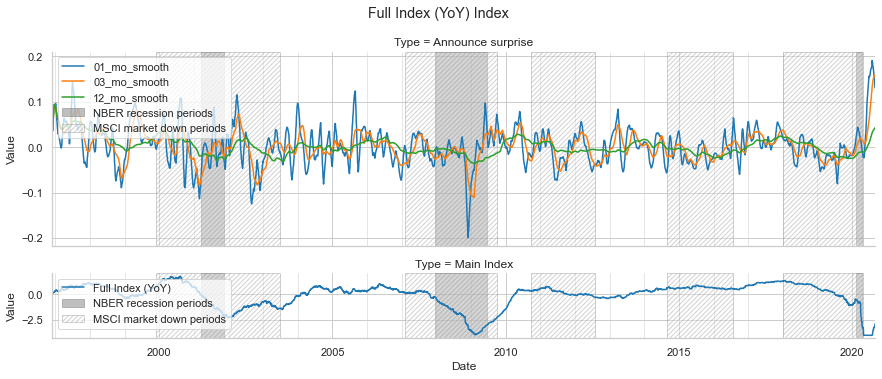

<Figure size 1080x360 with 0 Axes>

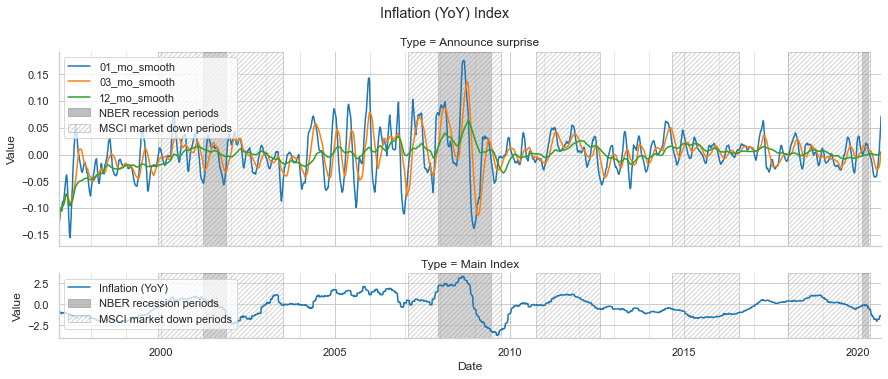

In [18]:
### RUN TO TESTING: ANNOUNCE SURPRISE INDEX VISUALIZING (MULTIPLE)

gc.collect()
### Recession periods loading:
df_nber_period = pd.read_hdf(str_path_nber_hdf, key = str_nber_periods_key)
### Market down periods loading:
df_msci_period = pd.read_hdf(str_path_msci_hdf, key = str_msci_market_down_key)  
### Global indices loading:
df_global = pd.concat([pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_full_yoy'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_inf_yoy')], axis = 1)
### Factors loading:
df_surprise_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
#df_surprise_full = pd.concat(dict_surprise, axis = 1).sort_index(axis = 1)
int_iter_len = len(df_surprise_full.columns) // 2
### Factors iterating:
for iter_type in range(2):
    ### Forecast factor extracting:
    ser_surprise_iter = df_surprise_full.iloc[:, iter_type * int_iter_len : (iter_type + 1) * int_iter_len - 1].dropna().stack()
    ser_surprise_iter.index.names = ['Date', 'Smoothing_length']
    ser_surprise_iter.name = 'Announce surprise'
    str_index_name = ser_surprise_iter.index[0][1].partition('_')[0]
    ### Forecast factor preparing to visualization:
    df_surprise_iter = ser_surprise_iter.reset_index()
    df_surprise_iter['Smoothing_length'] = df_surprise_iter['Smoothing_length'].str.partition('_')[2]
    df_surprise_iter.columns = ['Date', 'Option', 'Value']
    ### Index extracting:
    ser_index_iter = df_global.iloc[:, iter_type].loc[ser_surprise_iter.index.levels[0]].dropna()
    str_index_name = ser_index_iter.name
    df_index_iter = ser_index_iter.reset_index()
    df_index_iter.columns = ['Date', 'Value']
    df_index_iter['Option'] = str_index_name
    ### Plot creation:
    sns.set_style('whitegrid')
    plt.figure(figsize = (15, 5))
    sns.set_context('notebook') 
    date_min = max([ser_surprise_iter.index[0][0], ser_index_iter.index[0]])
    date_max = min([ser_surprise_iter.index[-1][0], ser_index_iter.index[-1]])    
    df_to_plot = pd.concat([df_surprise_iter, df_index_iter], axis = 0, names = ['Type'], keys = [ser_surprise_iter.name, 'Main Index'], sort = False)\
                   .droplevel(1).reset_index()   
    grid_iter_surprise = sns.FacetGrid(data = df_to_plot, row = 'Type', height = 2.5, aspect = 5.0, legend_out = False, sharey = False,
                                       gridspec_kws = {'height_ratios': (3, 1)})
    fig_iter_surprise = grid_iter_surprise.map(sns.lineplot, 'Date', 'Value', 'Option')    
    fig_iter_surprise.fig.suptitle(str_index_name + ' Index', y = 1.05)    
    fig_iter_surprise.set(xlim = (date_min, date_max))
    ### Axes customizing:
    for iter_ax in fig_iter_surprise.axes.ravel():
        ### Recession periods visualizing;
        for iter_num, iter_row in enumerate(df_nber_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'gray', edgecolor = 'gray', alpha = 0.50, 
                            label = '_' * iter_num + 'NBER recession periods')
        for iter_num, iter_row in enumerate(df_msci_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'white', edgecolor = 'gray', alpha = 0.35, hatch = '/////', 
                            label = '_' * iter_num + 'MSCI market down periods')             ### Major ticker options:    
        iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
        ### Minor ticker options:        
        iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5)                    
        ### Separate legend for each ax:
        iter_ax.legend(loc = 'upper left', framealpha = 0.75)        
    ### Index factor plot drawing:
    plt.show()

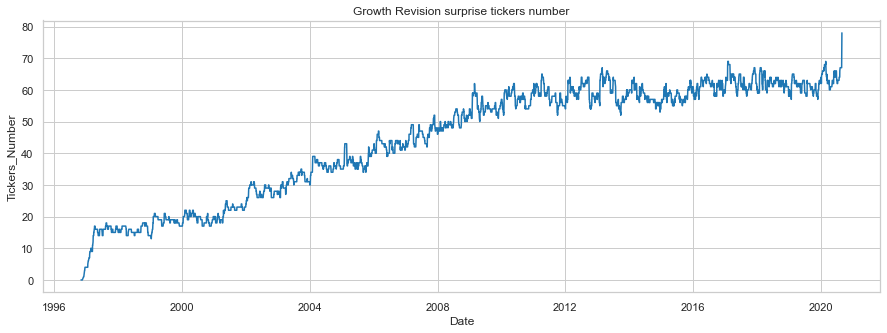

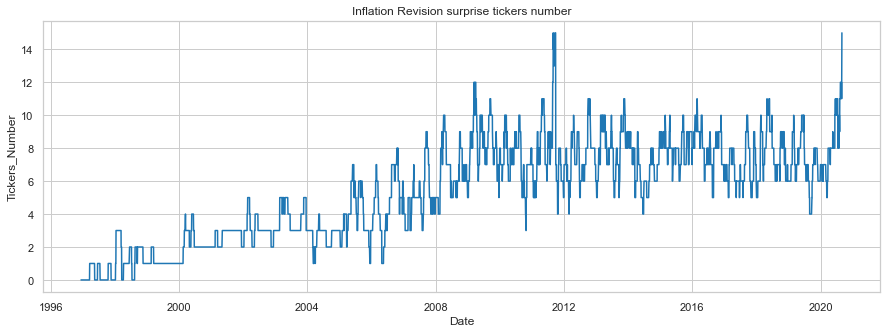

In [19]:
### RUN TO TEST: REVISION SURPRISE TICKERS NUMBER RESEARCH

### Defining index vector average calculator:
def release_date_surprise_count(df_date, int_min_tickers_to_go):
    ser_date_surprise = (df_date['Revision_Prev'] - df_date['Release_Prev'])
    return ser_date_surprise.count()
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
### Dropping zero stdev values:
df_surprise.loc[df_surprise['Forecast_Std'] < flo_winsorize_tolerance, 'Forecast_Std'] = np.NaN
### Data dividing:
dict_weighted = {}
dict_weighted['Growth'] = df_surprise[df_surprise['Growth'] == True]
dict_weighted['Inflation'] = df_surprise[df_surprise['Growth'] == False]
### Factors calculating:
dict_surprise = {}
for iter_key in dict_weighted:
    ser_surprise = dict_weighted[iter_key].dropna(how = 'all').groupby('Release_Date').apply(release_date_surprise_count, int_min_tickers_to_go)
    ser_surprise.index.name = 'Date'
    ser_surprise.name = 'Tickers_Number'
    ### Plot creation:
    sns.set_style('whitegrid')
    plt.figure(figsize = (15, 5))
    sns.set_context('notebook') 
    df_to_plot = ser_surprise.to_frame()
    ax_revisions = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Tickers_Number')
    ax_revisions.set_title(iter_key + ' Revision surprise tickers number')
    plt.show() 

In [12]:
### RUN TO RE-EXPORT DATA: REVISION SURPRISE INDEX CONSTRUCTING (SMOOTHED)

### Defining index vector average calculator:
def release_date_surprise(df_date, int_min_tickers_to_go):
    ser_date_surprise = (df_date['Revision_Prev'] - df_date['Release_Prev']).clip(list_clip[0], list_clip[1])
    if ser_date_surprise.count() >= int_min_tickers_to_go:
        flo_surprise = (ser_date_surprise * df_date['Ticker_Weight']).sum() / df_date['Ticker_Weight'].sum()
    else:
        flo_surprise = np.NaN
    return flo_surprise   
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
### Data dividing:
dict_weighted = {}
dict_weighted['Growth'] = df_surprise[df_surprise['Growth'] == True]
dict_weighted['Inflation'] = df_surprise[df_surprise['Growth'] == False]
### Factors calculating:
dict_surprise = {}
for iter_key in dict_weighted:
    ser_surprise = dict_weighted[iter_key].dropna(how = 'all').groupby('Release_Date').apply(release_date_surprise, int_min_tickers_to_go)
    ser_surprise.index.name = 'Date'
    ### Replace NaN values with zero:
    ser_surprise_valid = ser_surprise[ser_surprise.first_valid_index() : ]
    print(iter_key, ': NaN values after first valid: ', len(ser_surprise_valid[ser_surprise_valid.isna()].index))
    ser_surprise.loc[ser_surprise_valid[ser_surprise_valid.isna()].index] = 0.0
    ### Preparing to save:    
    ser_surprise = ser_surprise.reindex(pd.date_range(ser_surprise.index.min(), ser_surprise.index.max(), freq = 'B')).ffill()
    dict_surprise[iter_key + '_no_smooth'] = ser_surprise
    ### Looping over smoothing options:
    for iter_month_num in list_smooth:
        dict_surprise[iter_key + '_' + str(iter_month_num).zfill(2) + '_mo_smooth'] = \
                                                                    ser_surprise.rolling(window = int_bus_month * iter_month_num, min_periods = int_bus_min).mean()
#        break
#    break
### Factor saving:
pd.concat(dict_surprise, axis = 1).sort_index(axis = 1).to_hdf(str_path_bb_fcast_hdf, key = str_key_revision, mode = 'a')    

Growth : NaN values after first valid:  0
Inflation : NaN values after first valid:  1056


<Figure size 1080x360 with 0 Axes>

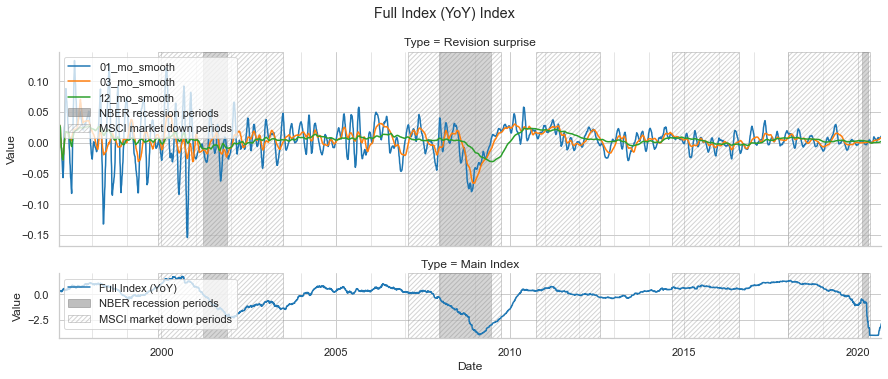

<Figure size 1080x360 with 0 Axes>

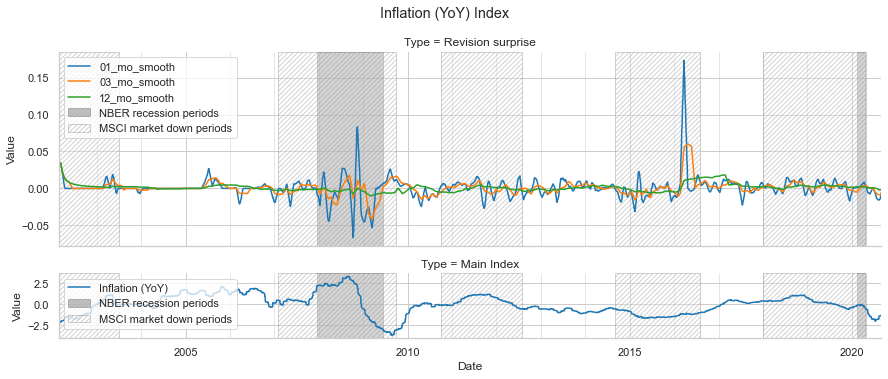

In [14]:
### RUN TO TESTING: REVISION SURPRISE INDEX VISUALIZING (MULTIPLE)

gc.collect()
### Recession periods loading:
df_nber_period = pd.read_hdf(str_path_nber_hdf, key = str_nber_periods_key)
### Market down periods loading:
df_msci_period = pd.read_hdf(str_path_msci_hdf, key = str_msci_market_down_key)  
### Global indices loading:
df_global = pd.concat([pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_full_yoy'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_inf_yoy')], axis = 1)
### Factors loading:
df_revision_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
int_iter_len = len(df_revision_full.columns) // 2
### Factors iterating:
for iter_type in range(2):
    ### Forecast factor extracting:
    ser_revision_iter = df_revision_full.iloc[:, iter_type * int_iter_len : (iter_type + 1) * int_iter_len - 1].dropna().stack()
    ser_revision_iter.index.names = ['Date', 'Smoothing_length']
    ser_revision_iter.name = 'Revision surprise'
    str_index_name = ser_revision_iter.index[0][1].partition('_')[0]
    ### Forecast factor preparing to visualization:
    df_revision_iter = ser_revision_iter.reset_index()
    df_revision_iter['Smoothing_length'] = df_revision_iter['Smoothing_length'].str.partition('_')[2]
    df_revision_iter.columns = ['Date', 'Option', 'Value']
    ### Index extracting:
    ser_index_iter = df_global.iloc[:, iter_type].loc[ser_revision_iter.index.levels[0]].dropna()
    str_index_name = ser_index_iter.name
    df_index_iter = ser_index_iter.reset_index()
    df_index_iter.columns = ['Date', 'Value']
    df_index_iter['Option'] = str_index_name
    ### Plot creation:
    sns.set_style('whitegrid')
    plt.figure(figsize = (15, 5))
    sns.set_context('notebook') 
    date_min = max([ser_revision_iter.index[0][0], ser_index_iter.index[0]])
    date_max = min([ser_revision_iter.index[-1][0], ser_index_iter.index[-1]])    
    df_to_plot = pd.concat([df_revision_iter, df_index_iter], axis = 0, names = ['Type'], keys = [ser_revision_iter.name, 'Main Index'], sort = False)\
                   .droplevel(1).reset_index()   
    grid_iter_revision = sns.FacetGrid(data = df_to_plot, row = 'Type', height = 2.5, aspect = 5.0, legend_out = False, sharey = False,
                                       gridspec_kws = {'height_ratios': (3, 1)})
    fig_iter_revision = grid_iter_revision.map(sns.lineplot, 'Date', 'Value', 'Option')    
    fig_iter_revision.fig.suptitle(str_index_name + ' Index', y = 1.05)    
    fig_iter_revision.set(xlim = (date_min, date_max))
    ### Axes customizing:
    for iter_ax in fig_iter_revision.axes.ravel():
        ### Recession periods visualizing;
        for iter_num, iter_row in enumerate(df_nber_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'gray', edgecolor = 'gray', alpha = 0.50, 
                            label = '_' * iter_num + 'NBER recession periods')
        for iter_num, iter_row in enumerate(df_msci_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'white', edgecolor = 'gray', alpha = 0.35, hatch = '/////', 
                            label = '_' * iter_num + 'MSCI market down periods')             
        ### Major ticker options:    
        iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
        ### Minor ticker options:        
        iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5)                    
        ### Separate legend for each ax:
        iter_ax.legend(loc = 'upper left', framealpha = 0.75)        
    ### Index factor plot drawing:
    plt.show()

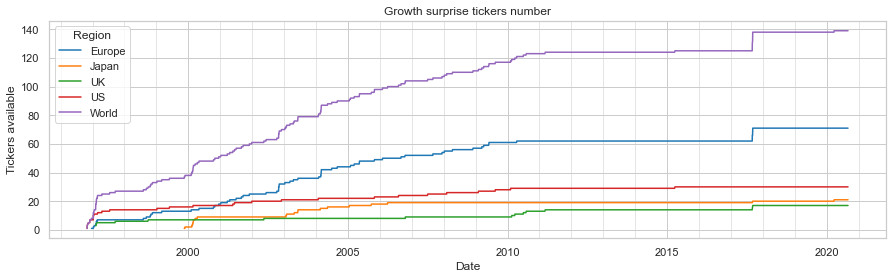

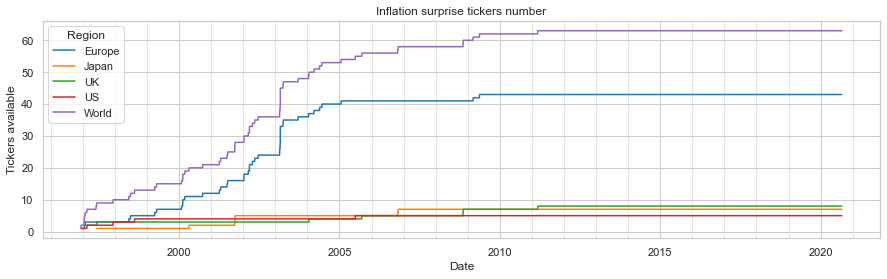

In [11]:
### RUN TO TEST: TOTAL SURPRISE TICKERS NUMBER RESEARCH

### Defining index vector average calculator:
def release_date_surprise_count(df_date, int_min_tickers_to_go):
    ser_date_announce = ((df_date['Release_Value'] - df_date['Survey_Median']) / df_date['Forecast_Std'])
    ser_date_revision = ((df_date['Revision_Prev'] - df_date['Release_Prev']) / df_date['Forecast_Std'])
    ser_date_surprise = pd.concat([ser_date_announce, ser_date_revision], axis = 1).sum(axis = 1)    
    return ser_date_surprise.count()
### Types and region export and clearing:
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
df_surprise = df_surprise.join(df_flags['Region'], on = 'Index_Name')
### Dropping zero stdev values:
df_surprise.loc[df_surprise['Forecast_Std'] < flo_winsorize_tolerance, 'Forecast_Std'] = np.NaN
### Data dividing:
dict_weighted = {}
dict_weighted['Growth'] = df_surprise[df_surprise['Growth'] == True]
dict_weighted['Inflation'] = df_surprise[df_surprise['Growth'] == False]
### Factors calculating:
dict_surprise = {}
for iter_key in dict_weighted:
    ser_surprise = dict_weighted[iter_key].dropna(how = 'all').groupby(['Release_Date', 'Region']).apply(release_date_surprise_count, int_min_tickers_to_go)
    df_surprise = ser_surprise.unstack('Region')
    df_surprise['World'] = df_surprise.sum(axis = 1)
    list_hue_order = df_surprise.columns.to_list()
    ### Plot creation:
    sns.set_style('whitegrid')
    plt.figure(figsize = (15, 4))
    sns.set_context('notebook') 
    df_to_plot = df_surprise.stack().astype(int).sort_index().reset_index()
    df_to_plot.columns = ['Date', 'Region', 'Tickers_Number']
    ax_revisions = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Tickers_Number', hue = 'Region', hue_order = list_hue_order)
    ax_revisions.set_title(iter_key + ' surprise tickers number')
    ax_revisions.set_ylabel('Tickers available')
    ### Major ticker options:    
    ax_revisions.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_revisions.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_revisions.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_revisions.grid(visible = True, which = 'minor', linewidth = 0.5)         
    
    plt.show()       

In [13]:
### RUN TO RE-EXPORT DATA: TOTAL SURPRISE INDEX CONSTRUCTING (SMOOTHED)

### Defining index vector average calculator:
def release_date_surprise(df_date, int_min_tickers_to_go):
    ser_date_announce = (df_date['Release_Value'] - df_date['Survey_Median'])
    ser_date_revision = (df_date['Revision_Prev'] - df_date['Release_Prev'])
    ser_date_surprise = pd.concat([ser_date_announce, ser_date_revision], axis = 1).sum(axis = 1).clip(list_clip[0], list_clip[1])
    if ser_date_surprise.count() >= int_min_tickers_to_go:
        flo_surprise = (ser_date_surprise * df_date['Ticker_Weight']).sum() / df_date['Ticker_Weight'].sum()
    else:
        flo_surprise = np.NaN
    return flo_surprise   
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
### Data dividing:
dict_weighted = {}
dict_weighted['Growth'] = df_surprise[df_surprise['Growth'] == True]
dict_weighted['Inflation'] = df_surprise[df_surprise['Growth'] == False]
### Factors calculating:
dict_surprise = {}
for iter_key in dict_weighted:
    ser_surprise = dict_weighted[iter_key].dropna(how = 'all').groupby('Release_Date').apply(release_date_surprise, int_min_tickers_to_go)
    ser_surprise.index.name = 'Date'
    ### Replace NaN values with zero:
    ser_surprise_valid = ser_surprise[ser_surprise.first_valid_index() : ]
    print(iter_key, ': NaN values after first valid: ', len(ser_surprise_valid[ser_surprise_valid.isna()].index))
    ser_surprise.loc[ser_surprise_valid[ser_surprise_valid.isna()].index] = 0.0
    ### Preparing to save:    
    ser_surprise = ser_surprise.reindex(pd.date_range(ser_surprise.index.min(), ser_surprise.index.max(), freq = 'B')).ffill()
    dict_surprise[iter_key + '_no_smooth'] = ser_surprise
    ### Looping over smoothing options:
    for iter_month_num in list_smooth:
        dict_surprise[iter_key + '_' + str(iter_month_num).zfill(2) + '_mo_smooth'] = \
                                                                    ser_surprise.rolling(window = int_bus_month * iter_month_num, min_periods = int_bus_min).mean()
#        break
#    break
### Factor saving:
pd.concat(dict_surprise, axis = 1).sort_index(axis = 1).to_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise, mode = 'a')    

Growth : NaN values after first valid:  0
Inflation : NaN values after first valid:  0


<Figure size 1080x360 with 0 Axes>

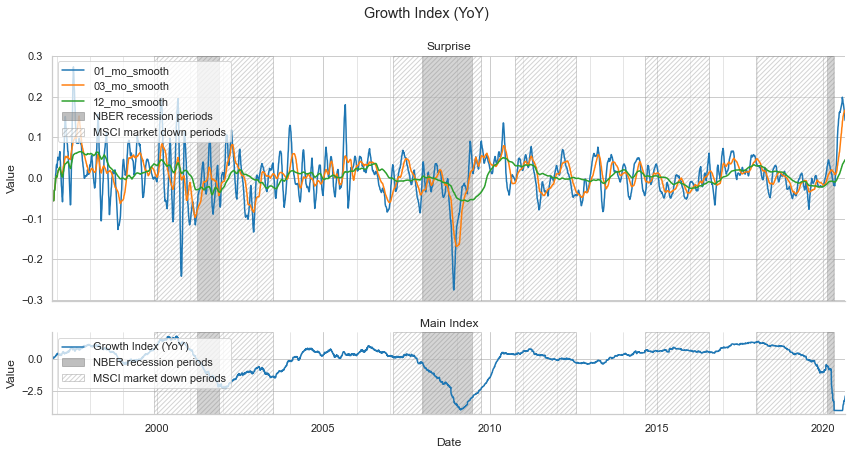

<Figure size 1080x360 with 0 Axes>

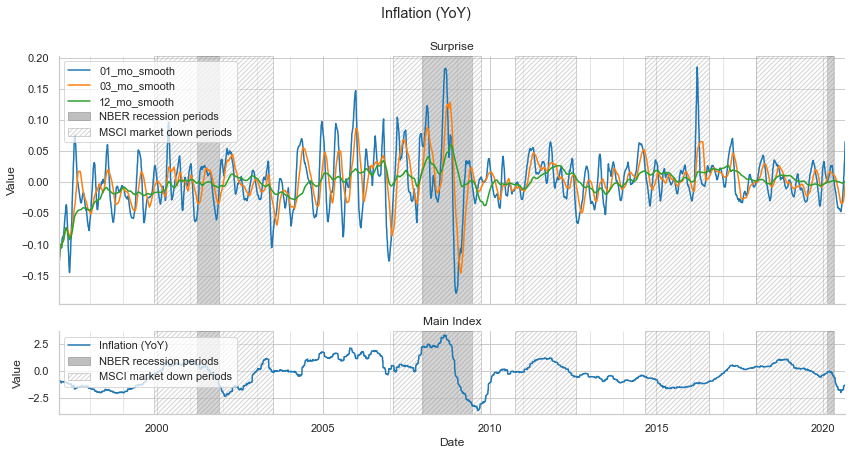

In [24]:
### RUN TO TESTING: TOTAL SURPRISE INDEX VISUALIZING (MULTIPLE)

gc.collect()
### Recession periods loading:
df_nber_period = pd.read_hdf(str_path_nber_hdf, key = str_nber_periods_key)
### Market down periods loading:
df_msci_period = pd.read_hdf(str_path_msci_hdf, key = str_msci_market_down_key)  
### Global indices loading:
df_global = pd.concat([pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_full_yoy'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_inf_yoy')], axis = 1)
### Factors loading:
df_total_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise)
int_iter_len = len(df_total_full.columns) // 2
### Factors iterating:
for iter_type in range(2):
    ### Forecast factor extracting:
    ser_total_iter = df_total_full.iloc[:, iter_type * int_iter_len : (iter_type + 1) * int_iter_len - 1].dropna().stack()
    ser_total_iter.index.names = ['Date', 'Smoothing_length']
    ser_total_iter.name = 'Total surprise'
    str_index_name = ser_total_iter.index[0][1].partition('_')[0]
    ### Forecast factor preparing to visualization:
    df_total_iter = ser_total_iter.reset_index()
    df_total_iter['Smoothing_length'] = df_total_iter['Smoothing_length'].str.partition('_')[2]
    df_total_iter.columns = ['Date', 'Option', 'Value']
    ### Index extracting:
    ser_index_iter = df_global.iloc[:, iter_type].loc[ser_total_iter.index.levels[0]].dropna()
    str_index_name = ser_index_iter.name.replace('Full', 'Growth')
    df_index_iter = ser_index_iter.reset_index()
    df_index_iter.columns = ['Date', 'Value']
    df_index_iter['Option'] = str_index_name
    ### Plot creation:
    sns.set_style('whitegrid')
    plt.figure(figsize = (15, 5))
    sns.set_context('notebook') 
    date_min = max([ser_total_iter.index[0][0], ser_index_iter.index[0]])
    date_max = min([ser_total_iter.index[-1][0], ser_index_iter.index[-1]])    
    df_to_plot = pd.concat([df_total_iter, df_index_iter], axis = 0, names = ['Type'], keys = ['Surprise', 'Main Index'], sort = False)\
                   .droplevel(1).reset_index()   
    grid_iter_total = sns.FacetGrid(data = df_to_plot, row = 'Type', height = 3.0, aspect = 4.0, legend_out = False, sharey = False,
                                       gridspec_kws = {'height_ratios': (3, 1)})
    fig_iter_total = grid_iter_total.map(sns.lineplot, 'Date', 'Value', 'Option')    
    fig_iter_total.fig.suptitle(str_index_name, y = 1.05)    
    fig_iter_total.set(xlim = (date_min, date_max))
    ### Axes customizing:
    for iter_ax in fig_iter_total.axes.ravel():
        ### Recession periods visualizing;
        for iter_num, iter_row in enumerate(df_nber_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'gray', edgecolor = 'gray', alpha = 0.50, 
                            label = '_' * iter_num + 'NBER recession periods')
        for iter_num, iter_row in enumerate(df_msci_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'white', edgecolor = 'gray', alpha = 0.35, hatch = '/////', 
                            label = '_' * iter_num + 'MSCI market down periods')             
        ### Title customization:        
        iter_ax.set_title(iter_ax.title.get_text().partition(' = ')[-1])            
        ### Major ticker options:
        iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
        ### Minor ticker options:        
        iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5)                    
        ### Separate legend for each ax:
        iter_ax.legend(loc = 'upper left', framealpha = 0.75)        
    ### Index factor plot drawing:
    plt.show()

<Figure size 1080x360 with 0 Axes>

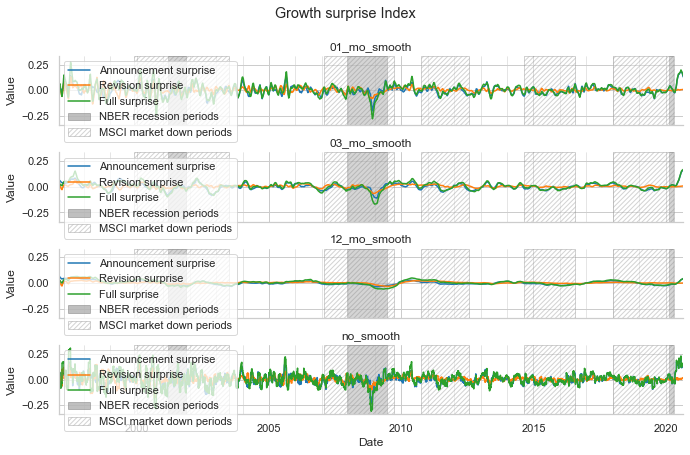

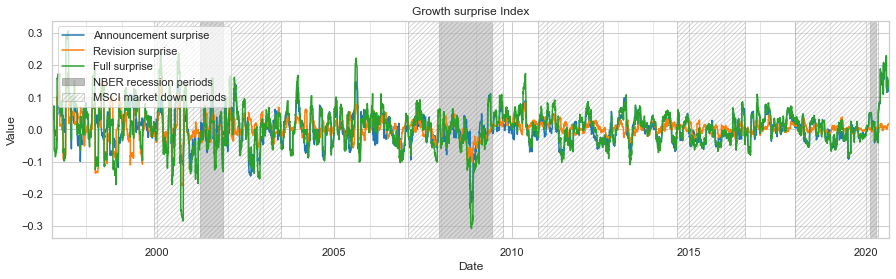

<Figure size 1080x360 with 0 Axes>

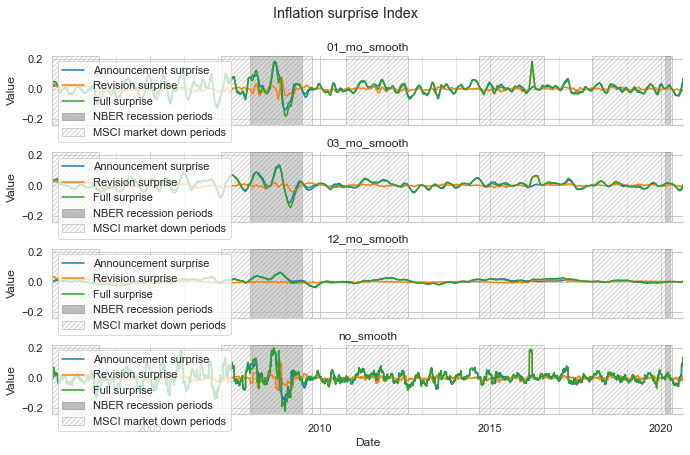

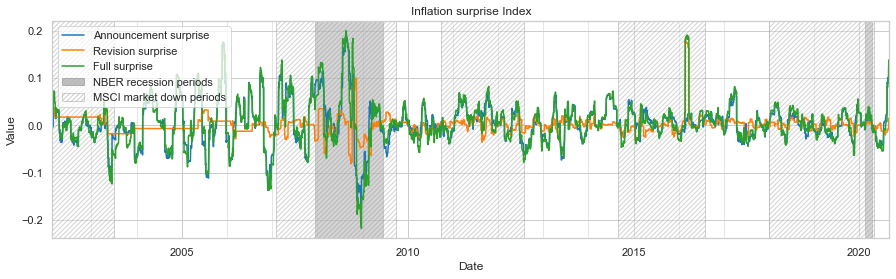

In [10]:
### RUN TO TESTING: SURPRISE INDICES COMPARISION (MULTIPLE)

gc.collect()
### Recession periods loading:
df_nber_period = pd.read_hdf(str_path_nber_hdf, key = str_nber_periods_key)
### Market down periods loading:
df_msci_period = pd.read_hdf(str_path_msci_hdf, key = str_msci_market_down_key)  
### Factors loading:
df_revision_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
df_announce_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
df_total_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise)
int_iter_len = len(df_revision_full.columns) // 2
### Factors iterating:
for iter_type in range(2):
    ### Forecast factors extracting:
    ser_announce_iter = df_announce_full.iloc[:, iter_type * int_iter_len : (iter_type + 1) * int_iter_len].dropna().stack()
    ser_announce_iter.index.names = ['Date', 'Smoothing_length']
    ser_announce_iter.name = 'Announcement surprise'
    ser_revision_iter = df_revision_full.iloc[:, iter_type * int_iter_len : (iter_type + 1) * int_iter_len].dropna().stack()
    ser_revision_iter.index.names = ['Date', 'Smoothing_length']
    ser_revision_iter.name = 'Revision surprise'
    ser_total_iter = df_total_full.iloc[:, iter_type * int_iter_len : (iter_type + 1) * int_iter_len].dropna().stack()
    ser_total_iter.index.names = ['Date', 'Smoothing_length']
    ser_total_iter.name = 'Full surprise'
    str_index_name = ser_announce_iter.index[0][1].partition('_')[0]     
    ### Forecast factor preparing to visualization:
    ser_forecast_iter = pd.concat([ser_announce_iter, ser_revision_iter, ser_total_iter], axis = 1).stack().sort_index()
    ser_forecast_iter.index.names = ['Date', 'Smoothing_length', 'Factor']
    ser_forecast_iter.name = 'Value'
    ### All smoothing ways plot creation:
    sns.set_style('whitegrid')
    plt.figure(figsize = (15, 5))
    sns.set_context('notebook') 
    date_min = max([ser_announce_iter.index[0][0], ser_revision_iter.index[0][0], ser_total_iter.index[0][0]])
    date_max = min([ser_announce_iter.index[-1][0], ser_revision_iter.index[-1][0], ser_total_iter.index[-1][0]])
    df_to_plot = ser_forecast_iter.reset_index()   
    df_to_plot['Smoothing_length'] = df_to_plot['Smoothing_length'].str.partition('_')[2]
    grid_iter_surprise = sns.FacetGrid(data = df_to_plot, row = 'Smoothing_length', height = 1.5, aspect = 6.5, legend_out = False, sharey = True)
    fig_iter_surprise = grid_iter_surprise.map(sns.lineplot, 'Date', 'Value', 'Factor', 
                                               hue_order = ['Announcement surprise', 'Revision surprise', 'Full surprise'])    
    fig_iter_surprise.fig.suptitle(str_index_name + ' surprise Index', y = 1.05)    
    fig_iter_surprise.set(xlim = (date_min, date_max))
    ### Axes customizing:
    for iter_ax in fig_iter_surprise.axes.ravel():
        ### Recession periods visualizing;
        for iter_num, iter_row in enumerate(df_nber_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'gray', edgecolor = 'gray', alpha = 0.50, 
                            label = '_' * iter_num + 'NBER recession periods')
        for iter_num, iter_row in enumerate(df_msci_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'white', edgecolor = 'gray', alpha = 0.35, hatch = '/////', 
                            label = '_' * iter_num + 'MSCI market down periods')   
        ### Title customization:        
        iter_ax.set_title(iter_ax.title.get_text().partition(' = ')[-1])
        ### Major ticker options:    
        iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y')) 
        ### Minor ticker options:        
        iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5)                    
        ### Separate legend for each ax:
        iter_ax.legend(loc = 'upper left', framealpha = 0.75)        
    ### Index factor plot drawing:
    plt.show()
    ### Not smoothed plot creation:
    sns.set_style('whitegrid')
    plt.figure(figsize = (15, 4))
    sns.set_context('notebook') 
    ax_no_surprise = sns.lineplot(data = df_to_plot[df_to_plot['Smoothing_length'] == 'no_smooth'], x = 'Date', y = 'Value', hue = 'Factor',
                                  hue_order = ['Announcement surprise', 'Revision surprise', 'Full surprise'])
    ax_no_surprise.set_title(str_index_name + ' surprise Index')    
    ax_no_surprise.set(xlim = (date_min, date_max))
    ### Recession periods visualizing;
    for iter_num, iter_row in enumerate(df_nber_period.itertuples()):
        ax_no_surprise.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'gray', edgecolor = 'gray', alpha = 0.50, 
                        label = '_' * iter_num + 'NBER recession periods')
    for iter_num, iter_row in enumerate(df_msci_period.itertuples()):
        ax_no_surprise.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'white', edgecolor = 'gray', alpha = 0.35, hatch = '/////', 
                        label = '_' * iter_num + 'MSCI market down periods')       
    ### Major ticker options:    
    ax_no_surprise.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_no_surprise.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y')) 
    ### Minor ticker options:        
    ax_no_surprise.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_no_surprise.grid(visible = True, which = 'minor', linewidth = 0.5)                    
    ### Separate legend for each ax:
    ax_no_surprise.legend(loc = 'upper left', framealpha = 0.75)         
    ### Index factor plot drawing:
    plt.show()    

In [10]:
### RUN TO TESTING: FORECAST INDICES - NBER RECESSION PERIODS STATS

### Factors loading:
df_announce = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
df_revision = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
df_total = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise)
df_factor = pd.concat([df_announce, df_revision, df_total], axis = 1, keys = ['Announcement Surprise Index', 'Revision Surprise Index', 'Total Surprise Index'])
### Replacing factor values with sign flags:
df_flags = pd.DataFrame(np.NaN, index = df_factor.index, columns = df_factor.columns)
df_flags[df_factor > 0.0] = 1
df_flags[df_factor <= 0.0] = 0
### Recession periods loading:
df_nber_periods = pd.read_hdf(str_path_nber_hdf, str_nber_periods_key)
### Adding out-of-recession periods:
df_nber_periods['Beg_Date_shifted'] = df_nber_periods['Beg_Date'].shift(-1).fillna(datetime_end)
### Average collections:
list_flag_period = []
list_flag_not = []
list_flag_before = []
list_flag_after = []
### NBER Recession periods looping:
for iter_period in df_nber_periods.itertuples():
    iter_index = iter_period.Index
    date_beg_period = iter_period.Beg_Date
    date_end_period = iter_period.End_Date
    date_shifted = iter_period.Beg_Date_shifted
    if (max(datetime_start, df_total.index[0]) < date_end_period):
        ### Recession periods determination:
        idx_period_iter = pd.date_range(start = date_beg_period, end = date_end_period, freq = 'B')
        idx_not_iter = pd.date_range(start = date_end_period, end = date_shifted, freq = 'B')                
        idx_before_iter = pd.date_range(start = date_beg_period - pd.DateOffset(months = 12), end = date_beg_period, freq = 'B')
        idx_after_iter = pd.date_range(start = date_end_period, end = date_end_period + pd.DateOffset(months = 12), freq = 'B')
        ### Mean values determination:
        list_flag_before.append(df_flags.reindex(idx_before_iter))
        list_flag_not.append(df_flags.reindex(idx_not_iter))           
        list_flag_period.append(df_flags.reindex(idx_period_iter))
        list_flag_after.append(df_flags.reindex(idx_after_iter))
### Average of periods mean:
ser_level_period_mean = round(pd.concat(list_flag_period).mean() - 0.50, 2)
ser_level_period_mean.name = 'Level: During recession periods mean'
ser_level_not_mean = round(pd.concat(list_flag_not).mean() - 0.50, 2)
ser_level_not_mean.name = 'Level: non-recession periods mean'
ser_level_before_mean = round(pd.concat(list_flag_before).mean() - 0.50, 2)
ser_level_before_mean.name = 'Level: 12-mo before recession periods mean'
ser_level_after_mean = round(pd.concat(list_flag_after).mean() - 0.50, 2)
ser_level_after_mean.name = 'Level: 12-mo after recession periods mean'
### Table aggregating:
df_nber_mean = pd.concat([ser_level_period_mean, ser_level_not_mean, ser_level_before_mean, ser_level_after_mean], axis = 1).transpose()
df_nber_mean.name = 'NBER Recession periods stats'
#print(df_nber_mean.name, ':')
#display(df_nber_mean)
df_nber_mean.to_excel('Data_Files/Test_Files/Some_Stats.xlsx', merge_cells = False)

In [11]:
### RUN TO TESTING: FORECAST INDICES - MSCI MARKET DOWN PERIODS STATS

### Factors loading:
df_announce = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
df_revision = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
df_total = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise)
df_factor = pd.concat([df_announce, df_revision, df_total], axis = 1, keys = ['Announcement Surprise Index', 'Revision Surprise Index', 'Total Surprise Index'])
### Replacing factor values with sign flags:
df_flags = pd.DataFrame(np.NaN, index = df_factor.index, columns = df_factor.columns)
df_flags[df_factor > 0.0] = 1
df_flags[df_factor <= 0.0] = 0
### Recession periods loading:
df_msci_periods = pd.read_hdf(str_path_msci_hdf, str_msci_market_down_key)
### Adding out-of-recession periods:
df_msci_periods['Beg_Date_shifted'] = df_msci_periods['Beg_Date'].shift(-1).fillna(datetime_end)
### Average collections:
list_flag_period = []
list_flag_not = []
list_flag_before = []
list_flag_after = []
### NBER Recession periods looping:
for iter_period in df_msci_periods.itertuples():
    iter_index = iter_period.Index
    date_beg_period = iter_period.Beg_Date
    date_end_period = iter_period.End_Date
    date_shifted = iter_period.Beg_Date_shifted
    if (max(datetime_start, df_total.index[0]) < date_end_period):
        ### Recession periods determination:
        idx_period_iter = pd.date_range(start = date_beg_period, end = date_end_period, freq = 'B')
        idx_not_iter = pd.date_range(start = date_end_period, end = date_shifted, freq = 'B')                
        idx_before_iter = pd.date_range(start = date_beg_period - pd.DateOffset(months = 12), end = date_beg_period, freq = 'B')
        idx_after_iter = pd.date_range(start = date_end_period, end = date_end_period + pd.DateOffset(months = 12), freq = 'B')
        ### Mean values determination:
        list_flag_before.append(df_flags.reindex(idx_before_iter))
        list_flag_not.append(df_flags.reindex(idx_not_iter))           
        list_flag_period.append(df_flags.reindex(idx_period_iter))
        list_flag_after.append(df_flags.reindex(idx_after_iter))
### Average of periods mean:
ser_level_period_mean = round(pd.concat(list_flag_period).mean() - 0.50, 2)
ser_level_period_mean.name = 'Level: During recession periods mean'
ser_level_not_mean = round(pd.concat(list_flag_not).mean() - 0.50, 2)
ser_level_not_mean.name = 'Level: non-recession periods mean'
ser_level_before_mean = round(pd.concat(list_flag_before).mean() - 0.50, 2)
ser_level_before_mean.name = 'Level: 12-mo before recession periods mean'
ser_level_after_mean = round(pd.concat(list_flag_after).mean() - 0.50, 2)
ser_level_after_mean.name = 'Level: 12-mo after recession periods mean'
### Table aggregating:
df_msci_mean = pd.concat([ser_level_period_mean, ser_level_not_mean, ser_level_before_mean, ser_level_after_mean], axis = 1).transpose()
df_msci_mean.name = 'MSCI Market Down periods stats'
#print(df_nber_mean.name, ':')
#display(df_nber_mean)
df_msci_mean.to_excel('Data_Files/Test_Files/Some_Stats.xlsx', merge_cells = False)

In [12]:
### RUN TO TESTING: FORECAST INDICES - CONSOLIDATED NBER RECESSION PERIODS STATS

### Factors loading:
df_announce_z = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
df_revision_z = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
df_total_z = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise)
df_factor_z = pd.concat([df_announce_z, df_revision_z, df_total_z], axis = 1, 
                        keys = ['Announcement Surprise Index', 'Revision Surprise Index', 'Total Surprise Index'])
### Replacing factor values with sign flags:
df_flags_z = pd.DataFrame(np.NaN, index = df_factor_z.index, columns = df_factor_z.columns)
df_flags_z[df_factor_z > 0.0] = 1
df_flags_z[df_factor_z <= 0.0] = 0
### Factors loading:
df_announce_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_announce)
df_revision_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_revision)
df_total_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_total_surprise)
df_factor_std = pd.concat([df_announce_std, df_revision_std, df_total_std], axis = 1, 
                          keys = ['Announcement Surprise Index', 'Revision Surprise Index', 'Total Surprise Index'])
### Replacing factor values with sign flags:
df_flags_std = pd.DataFrame(np.NaN, index = df_factor_std.index, columns = df_factor_std.columns)
df_flags_std[df_factor_std > 0.0] = 1
df_flags_std[df_factor_std <= 0.0] = 0
### Flags combining:
df_flags = (df_flags_z + df_flags_std) / 2
### Recession periods loading:
df_nber_periods = pd.read_hdf(str_path_nber_hdf, str_nber_periods_key)
### Adding out-of-recession periods:
df_nber_periods['Beg_Date_shifted'] = df_nber_periods['Beg_Date'].shift(-1).fillna(datetime_end)
### Average collections:
list_flag_period = []
list_flag_not = []
list_flag_before = []
list_flag_after = []
### NBER Recession periods looping:
for iter_period in df_nber_periods.itertuples():
    iter_index = iter_period.Index
    date_beg_period = iter_period.Beg_Date
    date_end_period = iter_period.End_Date
    date_shifted = iter_period.Beg_Date_shifted
    if (max(datetime_start, df_total_std.index[0]) < date_end_period):
        ### Recession periods determination:
        idx_period_iter = pd.date_range(start = date_beg_period, end = date_end_period, freq = 'B')
        idx_not_iter = pd.date_range(start = date_end_period, end = date_shifted, freq = 'B')                
        idx_before_iter = pd.date_range(start = date_beg_period - pd.DateOffset(months = 12), end = date_beg_period, freq = 'B')
        idx_after_iter = pd.date_range(start = date_end_period, end = date_end_period + pd.DateOffset(months = 12), freq = 'B')
        ### Mean values determination:
        list_flag_before.append(df_flags.reindex(idx_before_iter))
        list_flag_not.append(df_flags.reindex(idx_not_iter))           
        list_flag_period.append(df_flags.reindex(idx_period_iter))
        list_flag_after.append(df_flags.reindex(idx_after_iter))
### Average of periods mean:
ser_level_period_mean = round(pd.concat(list_flag_period).mean() - 0.50, 2)
ser_level_period_mean.name = 'Level: During recession periods mean'
ser_level_not_mean = round(pd.concat(list_flag_not).mean() - 0.50, 2)
ser_level_not_mean.name = 'Level: non-recession periods mean'
ser_level_before_mean = round(pd.concat(list_flag_before).mean() - 0.50, 2)
ser_level_before_mean.name = 'Level: 12-mo before recession periods mean'
ser_level_after_mean = round(pd.concat(list_flag_after).mean() - 0.50, 2)
ser_level_after_mean.name = 'Level: 12-mo after recession periods mean'
### Table aggregating:
df_nber_mean = pd.concat([ser_level_period_mean, ser_level_not_mean, ser_level_before_mean, ser_level_after_mean], axis = 1).transpose()
df_nber_mean.name = 'NBER Recession periods stats'
#print(df_nber_mean.name, ':')
#display(df_nber_mean)
df_nber_mean.to_excel('Data_Files/Test_Files/Some_Stats.xlsx', merge_cells = False)

In [10]:
### RUN TO TESTING: FORECAST INDICES - CONSOLIDATED MSCI MAARKET DOWN PERIODS STATS

### Factors loading:
df_announce_z = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
df_revision_z = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
df_total_z = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise)
df_factor_z = pd.concat([df_announce_z, df_revision_z, df_total_z], axis = 1, 
                        keys = ['Announcement Surprise Index', 'Revision Surprise Index', 'Total Surprise Index'])
### Replacing factor values with sign flags:
df_flags_z = pd.DataFrame(np.NaN, index = df_factor_z.index, columns = df_factor_z.columns)
df_flags_z[df_factor_z > 0.0] = 1
df_flags_z[df_factor_z <= 0.0] = 0
### Factors loading:
df_announce_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_announce)
df_revision_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_revision)
df_total_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_total_surprise)
df_factor_std = pd.concat([df_announce_std, df_revision_std, df_total_std], axis = 1, 
                          keys = ['Announcement Surprise Index', 'Revision Surprise Index', 'Total Surprise Index'])
### Replacing factor values with sign flags:
df_flags_std = pd.DataFrame(np.NaN, index = df_factor_std.index, columns = df_factor_std.columns)
df_flags_std[df_factor_std > 0.0] = 1
df_flags_std[df_factor_std <= 0.0] = 0
### Flags combining:
df_flags = (df_flags_z + df_flags_std) / 2
### Recession periods loading:
df_msci_periods = pd.read_hdf(str_path_msci_hdf, str_msci_market_down_key)
### Adding out-of-recession periods:
df_msci_periods['Beg_Date_shifted'] = df_msci_periods['Beg_Date'].shift(-1).fillna(datetime_end)
### Average collections:
list_flag_period = []
list_flag_not = []
list_flag_before = []
list_flag_after = []
### MSCI Recession periods looping:
for iter_period in df_msci_periods.itertuples():
    iter_index = iter_period.Index
    date_beg_period = iter_period.Beg_Date
    date_end_period = iter_period.End_Date
    date_shifted = iter_period.Beg_Date_shifted
    if (max(datetime_start, df_total_std.index[0]) < date_end_period):
        ### Recession periods determination:
        idx_period_iter = pd.date_range(start = date_beg_period, end = date_end_period, freq = 'B')
        idx_not_iter = pd.date_range(start = date_end_period, end = date_shifted, freq = 'B')                
        idx_before_iter = pd.date_range(start = date_beg_period - pd.DateOffset(months = 12), end = date_beg_period, freq = 'B')
        idx_after_iter = pd.date_range(start = date_end_period, end = date_end_period + pd.DateOffset(months = 12), freq = 'B')
        ### Mean values determination:
        list_flag_before.append(df_flags.reindex(idx_before_iter))
        list_flag_not.append(df_flags.reindex(idx_not_iter))           
        list_flag_period.append(df_flags.reindex(idx_period_iter))
        list_flag_after.append(df_flags.reindex(idx_after_iter))
### Average of periods mean:
ser_level_period_mean = round(pd.concat(list_flag_period).mean() - 0.50, 2)
ser_level_period_mean.name = 'Level: During recession periods mean'
ser_level_not_mean = round(pd.concat(list_flag_not).mean() - 0.50, 2)
ser_level_not_mean.name = 'Level: non-recession periods mean'
ser_level_before_mean = round(pd.concat(list_flag_before).mean() - 0.50, 2)
ser_level_before_mean.name = 'Level: 12-mo before recession periods mean'
ser_level_after_mean = round(pd.concat(list_flag_after).mean() - 0.50, 2)
ser_level_after_mean.name = 'Level: 12-mo after recession periods mean'
### Table aggregating:
df_msci_mean = pd.concat([ser_level_period_mean, ser_level_not_mean, ser_level_before_mean, ser_level_after_mean], axis = 1).transpose()
df_msci_mean.name = 'MSCI Market Down periods stats'
#print(df_msci_mean.name, ':')
#display(df_msci_mean)
df_msci_mean.to_excel('Data_Files/Test_Files/Some_Stats.xlsx', merge_cells = False)

In [15]:
### RUN TO TESTING: SURPRISE FACTORS COMPARING

### Alternative results loading:
df_announce = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
df_revision = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
df_total = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise)
### Column-wise correlation performing:
for iter_smooth in range(4):
    print(df_announce.columns[iter_smooth].partition('_')[0] + ' surprise (normalization by z-scoring): ' + df_announce.columns[iter_smooth].partition('_')[-1])
    display(pd.concat([df_announce[df_announce.columns[iter_smooth]], df_revision[df_revision.columns[iter_smooth]], df_total[df_total.columns[iter_smooth]]], 
                       axis = 1, keys = ['Announcement', 'Revision', 'Full']).corr().round(2))
    print(df_announce.columns[iter_smooth + 4].partition('_')[0] + ' surprise (normalization by z-scoring): ' + df_announce.columns[iter_smooth].partition('_')[-1])
    display(pd.concat([df_announce[df_announce.columns[iter_smooth + 4]], df_revision[df_revision.columns[iter_smooth + 4]], 
                       df_total[df_total.columns[iter_smooth + 4]]], 
                       axis = 1, keys = ['Announcement', 'Revision', 'Full']).corr().round(2))    

Growth surprise (normalization by z-scoring): 01_mo_smooth


,Announcement,Revision,Full
Announcement,1.00,0.25,0.87
Revision,0.25,1.00,0.68
Full,0.87,0.68,1.00


Inflation surprise (normalization by z-scoring): 01_mo_smooth


,Announcement,Revision,Full
Announcement,1.00,0.05,0.94
Revision,0.05,1.00,0.39
Full,0.94,0.39,1.00


Growth surprise (normalization by z-scoring): 03_mo_smooth


,Announcement,Revision,Full
Announcement,1.00,0.35,0.91
Revision,0.35,1.00,0.67
Full,0.91,0.67,1.00


Inflation surprise (normalization by z-scoring): 03_mo_smooth


,Announcement,Revision,Full
Announcement,1.00,0.09,0.95
Revision,0.09,1.00,0.37
Full,0.95,0.37,1.00


Growth surprise (normalization by z-scoring): 12_mo_smooth


,Announcement,Revision,Full
Announcement,1.00,0.56,0.87
Revision,0.56,1.00,0.80
Full,0.87,0.80,1.00


Inflation surprise (normalization by z-scoring): 12_mo_smooth


,Announcement,Revision,Full
Announcement,1.00,-0.08,0.97
Revision,-0.08,1.00,0.22
Full,0.97,0.22,1.00


Growth surprise (normalization by z-scoring): no_smooth


,Announcement,Revision,Full
Announcement,1.00,0.23,0.85
Revision,0.23,1.00,0.70
Full,0.85,0.70,1.00


Inflation surprise (normalization by z-scoring): no_smooth


,Announcement,Revision,Full
Announcement,1.00,0.04,0.92
Revision,0.04,1.00,0.42
Full,0.92,0.42,1.00


In [28]:
### RUN TO TESTING: SURPRISE FACTORS CALCULATION METHODS COMPARING

### Alternative results loading:
df_announce_matrix = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
df_revision_matrix = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
df_total_matrix = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise)
### Alternative results loading:
df_announce_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_announce)
df_revision_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_revision)
df_total_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_total_surprise)
### Pairwise correlations:
print('Announcement surprise correlation between matrix normalized and std normalized versions:\n', 
      df_announce_matrix[df_announce_matrix.columns[:4]].corrwith(df_announce_std[df_announce_std.columns[:4]]).round(2))
print('Revision surprise correlation between matrix normalized and std normalized versions:\n', 
      df_revision_matrix[df_revision_matrix.columns[:4]].corrwith(df_revision_std[df_revision_std.columns[:4]]).round(2))
print('Full surprise correlation between matrix normalized and std normalized versions:\n', 
      df_total_matrix[df_total_matrix.columns[:4]].corrwith(df_total_std[df_total_std.columns[:4]]).round(2))
### Pairwise correlations:
print('Announcement surprise correlation between matrix normalized and std normalized versions:\n', 
      df_announce_matrix[df_announce_matrix.columns[4:]].corrwith(df_announce_std[df_announce_std.columns[4:]]).round(2))
print('Revision surprise correlation between matrix normalized and std normalized versions:\n', 
      df_revision_matrix[df_revision_matrix.columns[4:]].corrwith(df_revision_std[df_revision_std.columns[4:]]).round(2))
print('Full surprise correlation between matrix normalized and std normalized versions:\n', 
      df_total_matrix[df_total_matrix.columns[4:]].corrwith(df_total_std[df_total_std.columns[4:]]).round(2))

Announcement surprise correlation between matrix normalized and std normalized versions:
 Growth_01_mo_smooth    0.75
Growth_03_mo_smooth    0.80
Growth_12_mo_smooth    0.80
Growth_no_smooth       0.73
dtype: float64
Revision surprise correlation between matrix normalized and std normalized versions:
 Growth_01_mo_smooth    0.44
Growth_03_mo_smooth    0.61
Growth_12_mo_smooth    0.85
Growth_no_smooth       0.39
dtype: float64
Full surprise correlation between matrix normalized and std normalized versions:
 Growth_01_mo_smooth    0.71
Growth_03_mo_smooth    0.78
Growth_12_mo_smooth    0.80
Growth_no_smooth       0.67
dtype: float64
Announcement surprise correlation between matrix normalized and std normalized versions:
 Inflation_01_mo_smooth    0.51
Inflation_03_mo_smooth    0.55
Inflation_12_mo_smooth    0.35
Inflation_no_smooth       0.48
dtype: float64
Revision surprise correlation between matrix normalized and std normalized versions:
 Inflation_01_mo_smooth    0.45
Inflation_03_mo

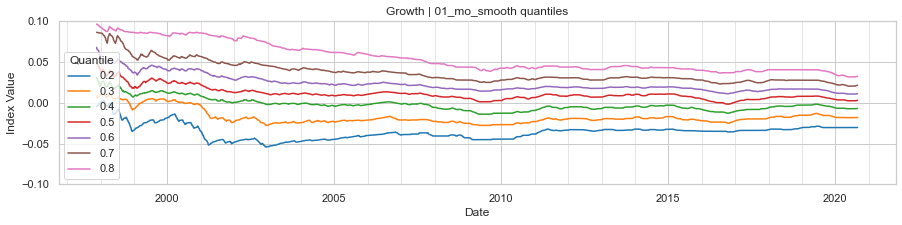

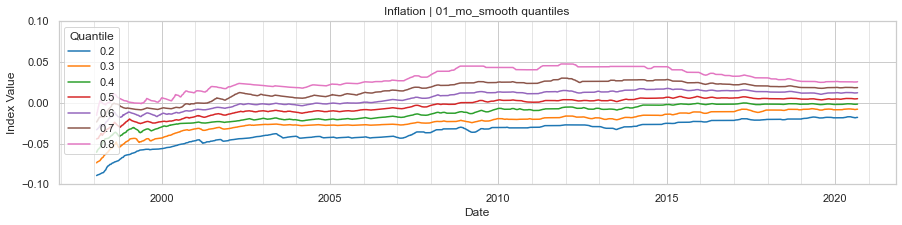

In [29]:
### RUN TO TEST: QUANTILES DRAWING

### Surprise indices loading:
dict_surprise = {}
#dict_surprise['Announcement Surprise'] = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
#dict_surprise['Revision Surprise'] = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
dict_surprise['Economic Surprise'] = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise)
### Looping over Surprise calculation ways:
for iter_surprise in dict_surprise:
    dict_iter_ptile = {}
    ### Looping over smoothing types:
    for iter_forecast in dict_surprise[iter_surprise].columns[[0, 4]]:
        ser_test_idx = dict_surprise[iter_surprise][iter_forecast]
        dict_quantile = {}
        for iter_quantile in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
            gc.collect()
            dict_quantile[str(iter_quantile)] = ser_test_idx.rolling(int_ptile_months_win * int_bus_month, min_periods = int_ptile_months_min * int_bus_month)\
                                                            .apply(lambda ser_win: ser_win.quantile(iter_quantile), raw = False)
        ser_quantile = pd.concat(dict_quantile, axis = 0)
        df_quantile = ser_quantile.reset_index()
        df_quantile.columns = ['Quantile', 'Date', 'Index_Value']
        ### Plot creation:
        sns.set_style('whitegrid')
        plt.figure(figsize = (15, 3))
        sns.set_context('notebook') 
        ax_quantiles = sns.lineplot(data = df_quantile, x = 'Date', y = 'Index_Value', hue = 'Quantile')
        ax_quantiles.set_title(iter_forecast.partition('_')[0] + ' | ' + iter_forecast.partition('_')[-1] + ' quantiles')
        ax_quantiles.set_ylim((-0.1, 0.1))
        ax_quantiles.set_ylabel('Index Value')
        ### Major ticker options:    
        ax_quantiles.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        ax_quantiles.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y')) 
        ### Minor ticker options:        
        ax_quantiles.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        ax_quantiles.grid(visible = True, which = 'minor', linewidth = 0.5)           
        plt.show()

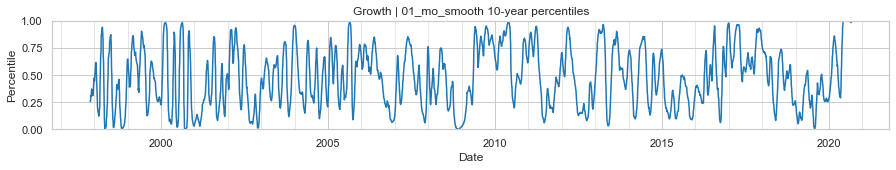

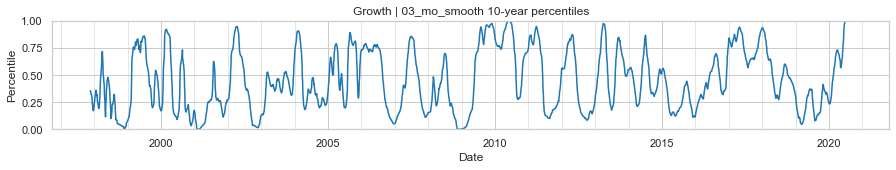

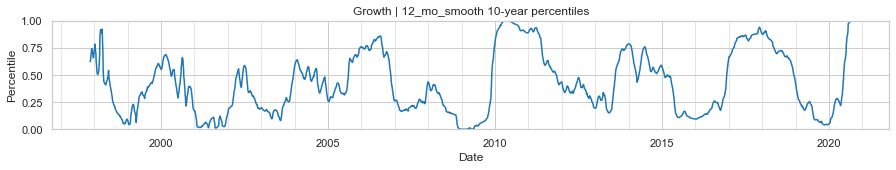

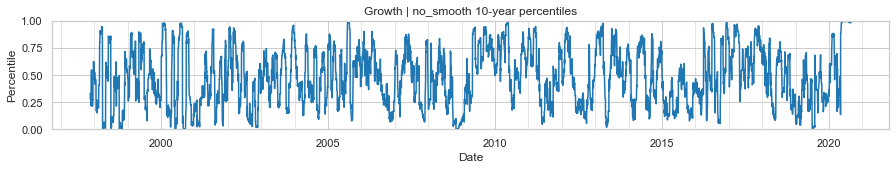

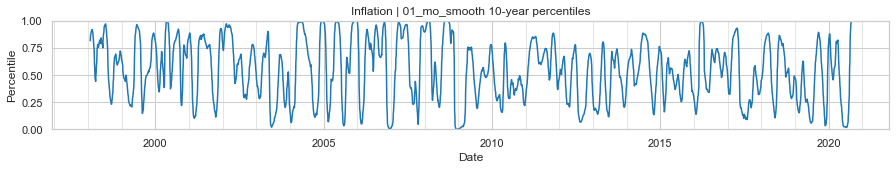

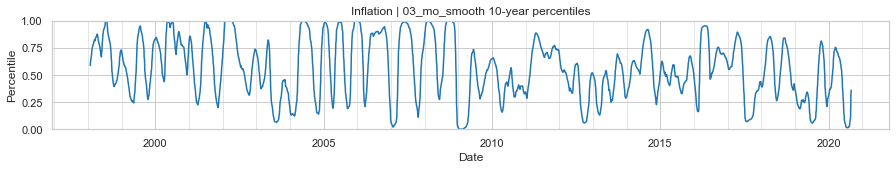

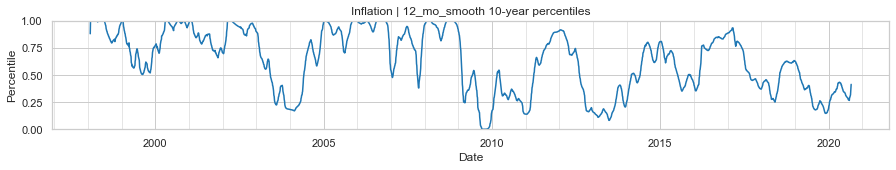

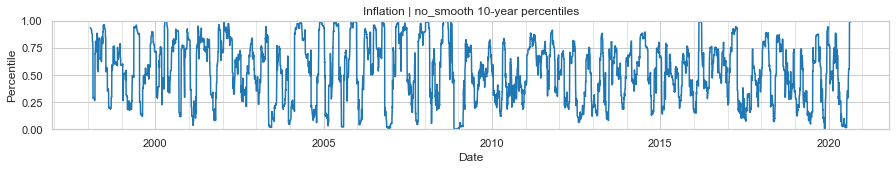

In [11]:
### RUN TO RE-EXPORT DATA: LEVEL PERCENTILE CONSTRUCTING

gc.collect()
### Defining percentiles generator:
def take_level_ptile(ser_date):
    ### Check for empty vector (doing nothing):
    if (ser_date.count() > 0):
        ### Level percentile calculation:
        flo_level_ptile = ser_date.rank(method = 'average', na_option = 'keep', ascending = True, pct = True).iloc[-1]
        ### Results output:
        return flo_level_ptile
    else:
        ### Results output:        
        return np.NaN
### Surprise indices loading:
dict_surprise = {}
#dict_surprise['Announcement Surprise'] = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
#dict_surprise['Revision Surprise'] = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
dict_surprise['Full Surprise'] = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise)
### Looping over surprise indices:    
dict_idx_ptile = {}
for iter_surprise in dict_surprise:
    dict_iter_ptile = {}
    ### Looping over smoothing types:        
    for iter_forecast in dict_surprise[iter_surprise].columns:
        dict_iter_ptile[iter_forecast] = dict_surprise[iter_surprise][iter_forecast]\
                                                            .rolling(int_ptile_months_win * int_bus_month, min_periods = int_ptile_months_min * int_bus_month)\
                                                            .apply(take_level_ptile, raw = False) 
        ### Plot data preparation:
        df_to_plot = dict_iter_ptile[iter_forecast].reset_index()
        df_to_plot.columns = ['Date', 'Percentile']
        ### Plot creation:
        sns.set_style('whitegrid')
        plt.figure(figsize = (15, 2.0))
        sns.set_context('notebook') 
        ax_ptiles = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percentile')
        ax_ptiles.set_title(iter_forecast.partition('_')[0] + ' | ' + iter_forecast.partition('_')[-1] + ' 10-year percentiles')
        ax_ptiles.set_ylim((0.0, 1.0))
        ### Major ticker options:    
        ax_ptiles.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        ax_ptiles.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y')) 
        ### Minor ticker options:        
        ax_ptiles.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        ax_ptiles.grid(visible = True, which = 'minor', linewidth = 0.5)             
        plt.show()
#        break
    ### Percentiles saving:
    dict_idx_ptile[iter_surprise] = pd.concat(dict_iter_ptile, axis = 1)
#    break

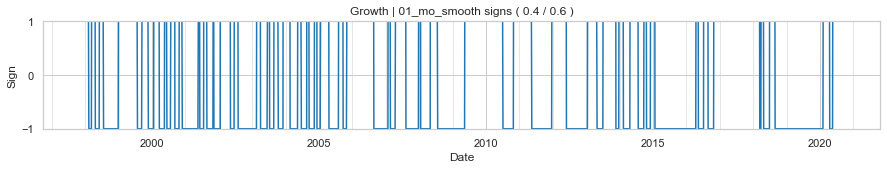

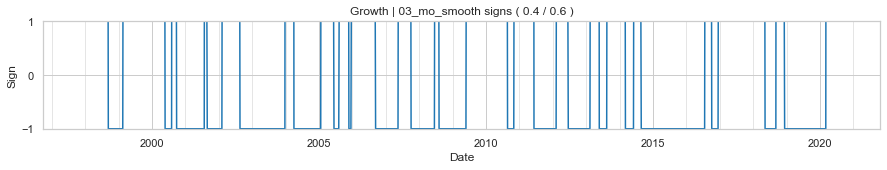

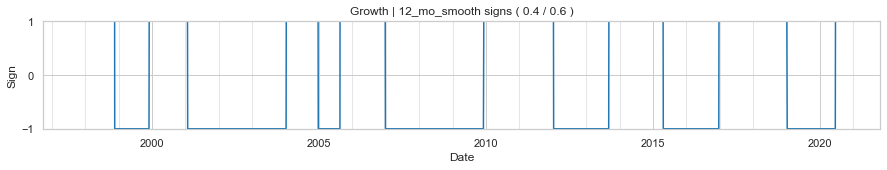

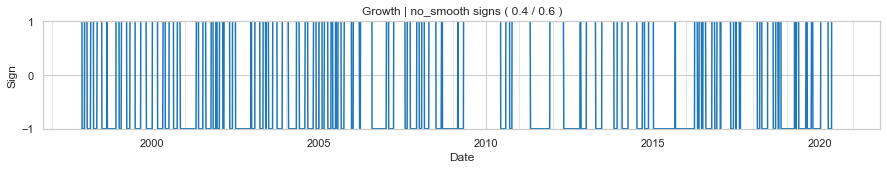

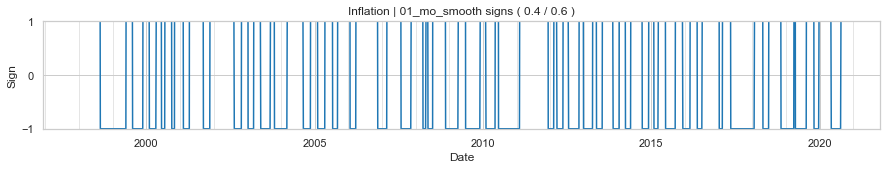

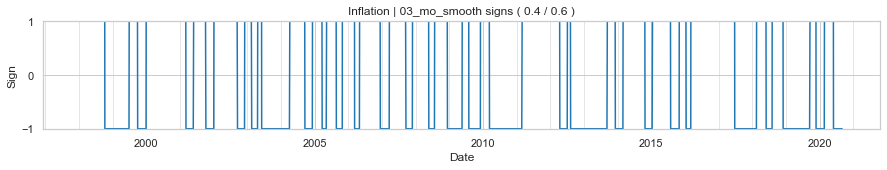

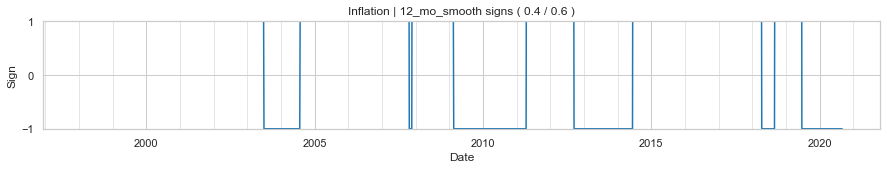

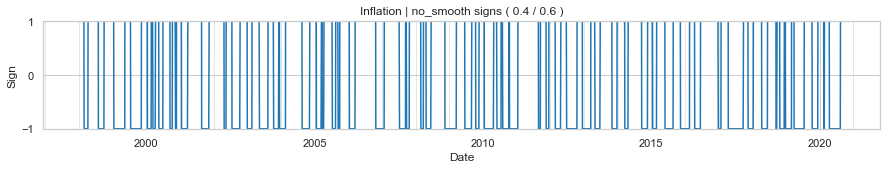

In [12]:
### RUN TO RE-EXPORT DATA: LEVEL SIGNS CONSTRUCTING

### Looping over surprise indices:
dict_idx_sign = {}
for iter_surprise in dict_idx_ptile:
    ### Looping over smoothing types:
    dict_iter_sign = {}
    for iter_forecast in dict_idx_ptile[iter_surprise].columns:
#        print(iter_surprise, '|', iter_forecast)
        ser_iter_ptile = dict_idx_ptile[iter_surprise][iter_forecast]
        ser_iter_ptile = ser_iter_ptile[ser_iter_ptile.first_valid_index() : ]
        ser_iter_idx = dict_surprise[iter_surprise][iter_forecast].reindex(ser_iter_ptile.index)
        ser_iter_sign = pd.Series(np.NaN, ser_iter_ptile.index)
        ser_iter_sign.iloc[0] = 1
        for iter_prev_num, iter_prev_date in enumerate(ser_iter_sign.index[: -1]):
            iter_this_num = iter_prev_num + 1
            if (ser_iter_sign[iter_prev_num] == 1):
                if ((ser_iter_idx[iter_this_num] < 0.0) & (ser_iter_ptile[iter_this_num] <= tumbler_to_minus)):
                    ser_iter_sign[iter_this_num] = -1
                else:
                    ser_iter_sign[iter_this_num] = 1
            else:
                if ((ser_iter_idx[iter_this_num] > 0.0) & (ser_iter_ptile[iter_this_num] >= tumbler_to_plus)):
                    ser_iter_sign[iter_this_num] = 1
                else:
                    ser_iter_sign[iter_this_num] = -1
        dict_iter_sign[iter_forecast] = ser_iter_sign
        ### Plot creation:
        sns.set_style('whitegrid')
        plt.figure(figsize = (15, 2))
        sns.set_context('notebook') 
        df_to_plot = ser_iter_sign.reset_index()
        df_to_plot.columns = ['Date', 'Sign']
        ax_quantiles = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Sign')
        ax_quantiles.set_title(iter_forecast.partition('_')[0] + ' | ' + iter_forecast.partition('_')[-1] + 
                               ' signs ( ' + str(tumbler_to_minus) + ' / ' + str(tumbler_to_plus) + ' )')
        ax_quantiles.set_ylim((-1.01, 1.01))
        ### Major ticker options:    
        ax_quantiles.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        ax_quantiles.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y')) 
        ### Minor ticker options:        
        ax_quantiles.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        ax_quantiles.grid(visible = True, which = 'minor', linewidth = 0.5)             
        plt.show()       
#        break
    dict_idx_sign[iter_surprise] = pd.concat(dict_iter_sign, axis = 1)        
#    break
### Signs saving:
pd.concat(dict_idx_sign).to_hdf(str_path_bb_fcast_hdf, key = str_key_signs, mode = 'a')

In [11]:
### RUN TO TEST: SIGNS BIAS RESEARCH

df_signs = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_signs)
#print('Observations number:\n', df_signs.count())
#print('Signs sum:\n', df_signs.sum())
print('Bias :\n', df_signs.sum() / df_signs.count())
df_total = df_signs.loc['Full Surprise'].dropna()
df_changes = pd.DataFrame(np.NaN, index = df_total.index, columns = df_total.columns)
for iter_col in df_changes.columns:
    print(iter_col, ': Average sign changes per year :',
        round((np.sign(df_total[iter_col]) != np.sign(df_total[iter_col].shift().loc[df_total[iter_col].index]))\
                  .fillna(False).astype(int).resample('BY').sum().mean(), 2))

Bias :
 Growth_01_mo_smooth      -0.059406
Growth_03_mo_smooth      -0.081121
Growth_12_mo_smooth       0.006076
Growth_no_smooth         -0.066382
Inflation_01_mo_smooth    0.052985
Inflation_03_mo_smooth    0.089165
Inflation_12_mo_smooth    0.342052
Inflation_no_smooth       0.049930
dtype: float64
Growth_01_mo_smooth : Average sign changes per year : 3.78
Growth_03_mo_smooth : Average sign changes per year : 1.78
Growth_12_mo_smooth : Average sign changes per year : 0.65
Growth_no_smooth : Average sign changes per year : 6.43
Inflation_01_mo_smooth : Average sign changes per year : 3.7
Inflation_03_mo_smooth : Average sign changes per year : 2.43
Inflation_12_mo_smooth : Average sign changes per year : 0.52
Inflation_no_smooth : Average sign changes per year : 5.17


In [26]:
### RUN TO TEST: SIGNS BIAS RESEARCH

df_signs_z = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_signs)
df_signs_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_signs)
df_signs = ((df_signs_z + df_signs_std) / 2)
#print('Observations number:\n', df_signs.count())
#print('Signs sum:\n', df_signs.sum())
print('Bias :\n', df_signs.sum() / df_signs.count())
df_total = df_signs.loc['Full Surprise'].dropna().replace(0, 1)
df_changes = pd.DataFrame(np.NaN, index = df_total.index, columns = df_total.columns)
for iter_col in df_changes.columns:
    print(iter_col, ': Average sign changes per year :',
        round((np.sign(df_total[iter_col]) != np.sign(df_total[iter_col].shift().loc[df_total[iter_col].index]))\
                  .fillna(False).astype(int).resample('BY').sum().mean(), 2))

Bias :
 Growth_01_mo_smooth      -0.053145
Growth_03_mo_smooth      -0.050253
Growth_12_mo_smooth      -0.065618
Growth_no_smooth         -0.026753
Inflation_01_mo_smooth    0.031538
Inflation_03_mo_smooth    0.048322
Inflation_12_mo_smooth    0.222427
Inflation_no_smooth       0.044080
dtype: float64
Growth_01_mo_smooth : Average sign changes per year : 3.95
Growth_03_mo_smooth : Average sign changes per year : 1.77
Growth_12_mo_smooth : Average sign changes per year : 0.5
Growth_no_smooth : Average sign changes per year : 6.64
Inflation_01_mo_smooth : Average sign changes per year : 4.14
Inflation_03_mo_smooth : Average sign changes per year : 2.5
Inflation_12_mo_smooth : Average sign changes per year : 0.5
Inflation_no_smooth : Average sign changes per year : 5.41


In [36]:
### RUN TO TEST: SIGNS BIAS RESEARCH

dict_signs = {}
dict_signs['Z'] = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_signs)
dict_signs['Std'] = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_signs)
dict_signs['Total'] = ((dict_signs['Z'] + dict_signs['Std']) / 2)

for iter_way in dict_signs:
    df_signs = dict_signs[iter_way]
    print(iter_way, ': Bias :\n', df_signs.sum() / df_signs.count())
    for iter_col in df_signs.columns:
        print(iter_way, ':', iter_col, 'turnovers per year \n', round((df_signs - df_signs.shift()).abs()[iter_col].droplevel(0).resample('BY').sum().mean(), 2))

Z : Bias :
 Growth_01_mo_smooth      -0.067631
Growth_03_mo_smooth      -0.065949
Growth_12_mo_smooth      -0.084118
Growth_no_smooth         -0.045424
Inflation_01_mo_smooth    0.059023
Inflation_03_mo_smooth    0.113976
Inflation_12_mo_smooth    0.413161
Inflation_no_smooth       0.114315
dtype: float64
Z : Growth_01_mo_smooth turnovers per year 
 7.17
Z : Growth_03_mo_smooth turnovers per year 
 3.33
Z : Growth_12_mo_smooth turnovers per year 
 1.17
Z : Growth_no_smooth turnovers per year 
 12.5
Z : Inflation_01_mo_smooth turnovers per year 
 7.0
Z : Inflation_03_mo_smooth turnovers per year 
 4.58
Z : Inflation_12_mo_smooth turnovers per year 
 0.92
Z : Inflation_no_smooth turnovers per year 
 9.83
Std : Bias :
 Growth_01_mo_smooth      -0.020607
Growth_03_mo_smooth       0.003615
Growth_12_mo_smooth      -0.020607
Growth_no_smooth         -0.011208
Inflation_01_mo_smooth   -0.015124
Inflation_03_mo_smooth   -0.022501
Inflation_12_mo_smooth    0.082995
Inflation_no_smooth      -0.0

In [25]:
### TEMP



6.25

In [37]:
### RUN TO TESTING: SURPRISE FACTORS CALCULATION METHODS COMPARING

### Alternative results loading:
df_announce_signs_matrix = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_signs).loc['Announcement Surprise']
df_revision_signs_matrix = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_signs).loc['Revision Surprise']
df_total_signs_matrix = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_signs).loc['Full Surprise']
### Alternative results loading:
df_announce_signs_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_signs).loc['Announcement Surprise']
df_revision_signs_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_signs).loc['Revision Surprise']
df_total_signs_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_signs).loc['Full Surprise']
### Pairwise correlations:
print('Announce surprise signs correlation between matrix normalized and std normalized versions:\n', 
      round(df_announce_signs_matrix[df_announce_signs_matrix.columns[:4]].corrwith(df_announce_signs_std[df_announce_signs_std.columns[:4]]), 2))
print('Revision surprise signs correlation between matrix normalized and std normalized versions:\n', 
      round(df_revision_signs_matrix[df_revision_signs_matrix.columns[:4]].corrwith(df_revision_signs_std[df_revision_signs_std.columns[:4]]), 2))
print('Total surprise signs correlation between matrix normalized and std normalized versions:\n', 
      round(df_total_signs_matrix[df_total_signs_matrix.columns[:4]].corrwith(df_total_signs_std[df_total_signs_std.columns[:4]]), 2))
print('Announce surprise signs correlation between matrix normalized and std normalized versions:\n', 
      round(df_announce_signs_matrix[df_announce_signs_matrix.columns[4:]].corrwith(df_announce_signs_std[df_announce_signs_std.columns[4:]]), 2))
print('Revision surprise signs correlation between matrix normalized and std normalized versions:\n', 
      round(df_revision_signs_matrix[df_revision_signs_matrix.columns[4:]].corrwith(df_revision_signs_std[df_revision_signs_std.columns[4:]]), 2))
print('Total surprise signs correlation between matrix normalized and std normalized versions:\n', 
      round(df_total_signs_matrix[df_total_signs_matrix.columns[4:]].corrwith(df_total_signs_std[df_total_signs_std.columns[4:]]), 2))

Announce surprise signs correlation between matrix normalized and std normalized versions:
 Growth_01_mo_smooth    0.64
Growth_03_mo_smooth    0.73
Growth_12_mo_smooth    0.80
Growth_no_smooth       0.59
dtype: float64
Revision surprise signs correlation between matrix normalized and std normalized versions:
 Growth_01_mo_smooth    0.38
Growth_03_mo_smooth    0.37
Growth_12_mo_smooth    0.69
Growth_no_smooth       0.39
dtype: float64
Total surprise signs correlation between matrix normalized and std normalized versions:
 Growth_01_mo_smooth    0.64
Growth_03_mo_smooth    0.69
Growth_12_mo_smooth    0.76
Growth_no_smooth       0.55
dtype: float64
Announce surprise signs correlation between matrix normalized and std normalized versions:
 Inflation_01_mo_smooth    0.31
Inflation_03_mo_smooth    0.28
Inflation_12_mo_smooth    0.14
Inflation_no_smooth       0.31
dtype: float64
Revision surprise signs correlation between matrix normalized and std normalized versions:
 Inflation_01_mo_smooth 

In [14]:
### TEMP

df_signs = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_signs)#.loc['Full Surprise']
df_signs.to_excel('Data_Files/Test_Files/Signs_z.xlsx', merge_cells = False)